# Business Statement
This project aims to enhance the current weather detection mechanism by developing an optimal prediction model along with necessary implementation techniques that can complement traditional forecast models. Rapidly changing weather conditions often go unnoticed by traditional forecasting methods, resulting in a lack of instantaneous information about these changes. By incorporating live pictures of weather patterns approaching specific regions, this model can capture and classify the upcoming weather swiftly. Thus, it provides valuable and timely information about the imminent weather changes, serving as a valuable enhancement to the existing weather detection approach.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive


Mounted at /content/drive
/content/drive/My Drive


# Import the packages

In [60]:
#Import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import re
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog, canny
from skimage.filters import sobel
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import LabelEncoder
from numpy import expand_dims
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Import dataset and get ready for modelling

In [4]:
path="/content/drive/My Drive/weather"
cloudy=path+'/cloudy'
rain=path+'/rain'
shine=path+'/shine'
sunrise=path+'/sunrise'

In [5]:
df=pd.DataFrame()

In [6]:
df['pictures']=os.listdir(cloudy)+os.listdir(rain)+os.listdir(shine)+os.listdir(sunrise)

In [7]:
stored_label=[]
stored_paths=[]
for picture_name in df['pictures']:
  label=re.match(r'([a-zA-Z]+)', picture_name).group()
  stored_label.append(label)
  stored_paths.append(path+'/'+label+'/'+picture_name)

In [8]:
df['label']=stored_label
df['path']=stored_paths

In [9]:
df.head()

pictures   label                                               path
0  cloudy103.jpg  cloudy  /content/drive/My Drive/weather/cloudy/cloudy1...
1    cloudy1.jpg  cloudy  /content/drive/My Drive/weather/cloudy/cloudy1...
2  cloudy101.jpg  cloudy  /content/drive/My Drive/weather/cloudy/cloudy1...
3  cloudy104.jpg  cloudy  /content/drive/My Drive/weather/cloudy/cloudy1...
4   cloudy10.jpg  cloudy  /content/drive/My Drive/weather/cloudy/cloudy1...

# Check for missing data

In [10]:
df.isna().sum()

pictures    0
label       0
path        0
dtype: int64

# Exploratory Data Analysis

# Explore the number of images in each category

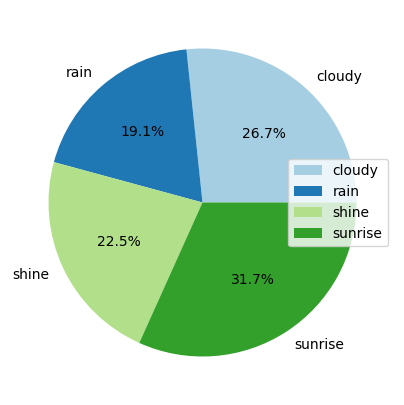

In [11]:
plt.figure(figsize=(5,5))
class_cnt = df.groupby(['label']).size().reset_index(name = 'counts')
colors = sns.color_palette('Paired')[0:9]
plt.pie(class_cnt['counts'], labels=class_cnt['label'], colors=colors, autopct='%1.1f%%')
plt.legend(loc='right')
plt.show()

# Visualization

plot a representative from each category

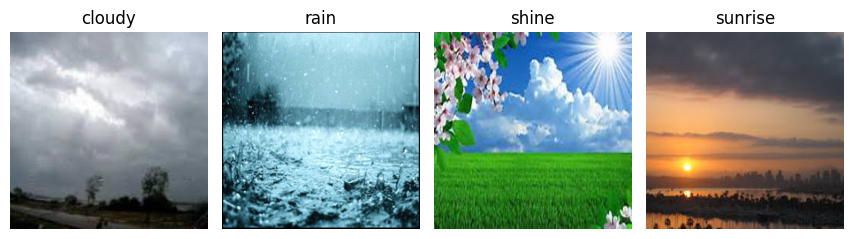

In [12]:
plt.figure(figsize = (15,12))
for idx,m in enumerate(df.label.unique()):
    plt.subplot(4,7,idx+1)
    rep_df = df[df['label'] ==m].reset_index(drop = True)
    image_path = rep_df.loc[random.randint(0, len(rep_df))-1,'path']
    img = Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(m)
plt.tight_layout()
plt.show()

# Explore Image Sizes

In [13]:
widths,heights=[],[]
for path in tqdm(df['path']):
  widths.append(Image.open(path).size[0])
  heights.append(Image.open(path).size[1])

100%|██████████| 1125/1125 [07:45<00:00,  2.42it/s]


In [14]:
df['width']=widths
df['height']=heights

In [15]:
df

pictures    label  \
0     cloudy103.jpg   cloudy   
1       cloudy1.jpg   cloudy   
2     cloudy101.jpg   cloudy   
3     cloudy104.jpg   cloudy   
4      cloudy10.jpg   cloudy   
...             ...      ...   
1120  sunrise86.jpg  sunrise   
1121  sunrise97.jpg  sunrise   
1122  sunrise99.jpg  sunrise   
1123  sunrise96.jpg  sunrise   
1124  sunrise98.jpg  sunrise   

                                                   path  width  height  
0     /content/drive/My Drive/weather/cloudy/cloudy1...    275     183  
1     /content/drive/My Drive/weather/cloudy/cloudy1...    600     400  
2     /content/drive/My Drive/weather/cloudy/cloudy1...    338     149  
3     /content/drive/My Drive/weather/cloudy/cloudy1...    275     183  
4     /content/drive/My Drive/weather/cloudy/cloudy1...    271     186  
...                                                 ...    ...     ...  
1120  /content/drive/My Drive/weather/sunrise/sunris...    276     183  
1121  /content/drive/My Drive/weather/sunrise/sunris...    300     168  
1122  /content/drive/My Drive/weather/sunrise/sunris...    283     178  
1123  /content/drive/My Drive/weather/sunrise/sunris...   3008    2000  
1124  /content/drive/My Drive/weather/sunrise/sunris...   1024     576  

[1125 rows x 5 columns]

In [16]:
df.describe()

width       height
count  1125.000000  1125.000000
mean    506.335111   334.777778
std     539.274611   355.133806
min     158.000000    94.000000
25%     259.000000   168.000000
50%     284.000000   183.000000
75%     600.000000   384.000000
max    4752.000000  3195.000000

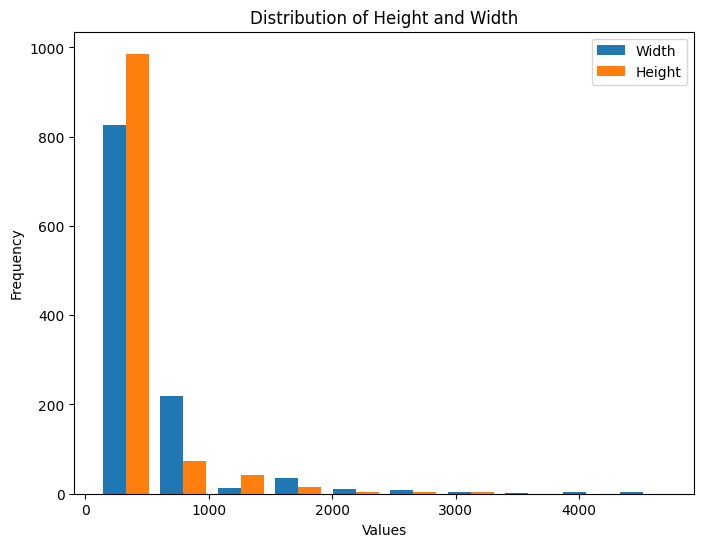

In [17]:
plt.figure(figsize=(8, 6))
plt.hist([df['width'],df['height']], bins=10, label=['Width', 'Height'])
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Height and Width')
plt.legend()
plt.show()

It appears that the majority of the images have width or height smaller than 1000

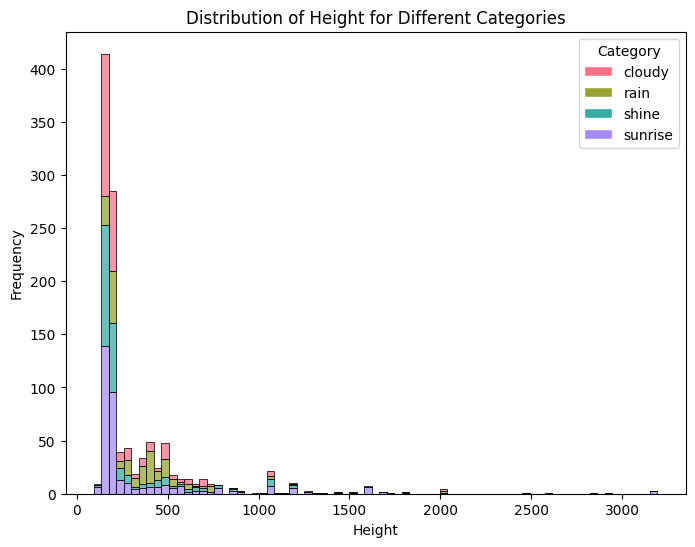

In [18]:
# Plotting the grouped histogram
unique_categories = df['label'].unique()
colors = sns.color_palette('husl', n_colors=len(unique_categories))
sns.set_palette(colors)

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='height', hue='label', multiple='stack')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Distribution of Height for Different Categories')
plt.legend(title='Category')


# Create custom legend handles
legend_handles = [Patch(facecolor=colors[i], edgecolor='w', label=category) for i, category in enumerate(unique_categories)]

plt.legend(handles=legend_handles, title='Category', loc='upper right')
plt.show()

It appears that the height is distributed unevenly among different categories

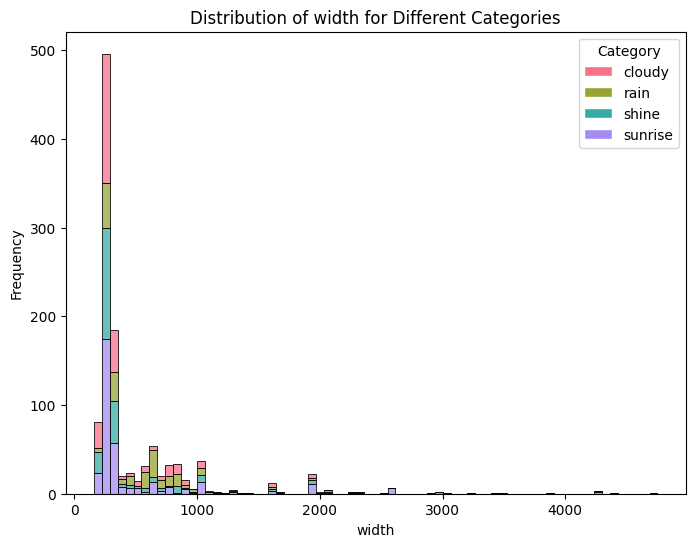

In [19]:
# Plotting the grouped histogram
unique_categories = df['label'].unique()
colors = sns.color_palette('husl', n_colors=len(unique_categories))
sns.set_palette(colors)

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='width', hue='label', multiple='stack')
plt.xlabel('width')
plt.ylabel('Frequency')
plt.title('Distribution of width for Different Categories')
plt.legend(title='Category')


# Create custom legend handles
legend_handles = [Patch(facecolor=colors[i], edgecolor='w', label=category) for i, category in enumerate(unique_categories)]

plt.legend(handles=legend_handles, title='Category', loc='upper right')
plt.show()

Similar inference may be drawn for the case of width

# Explore images in some edges

Processing image: /content/drive/My Drive/weather/cloudy/cloudy84.jpg


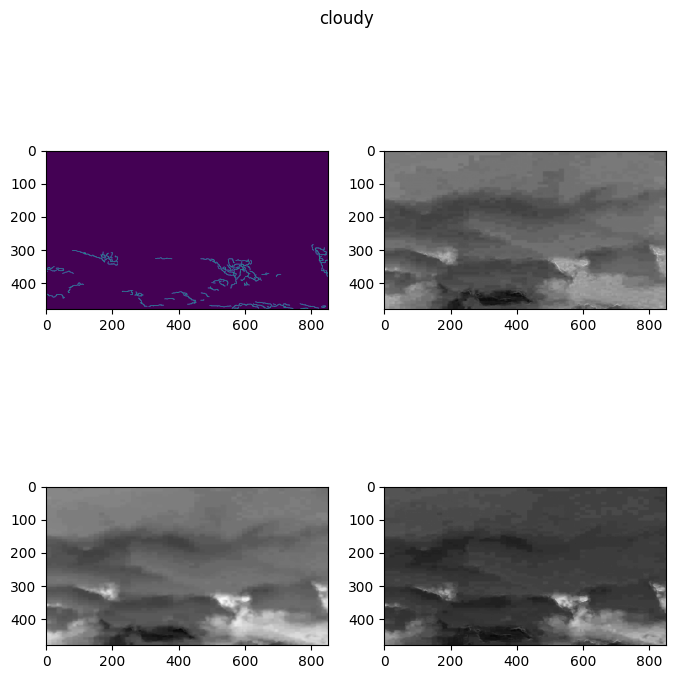

Processing image: /content/drive/My Drive/weather/shine/shine153.jpg


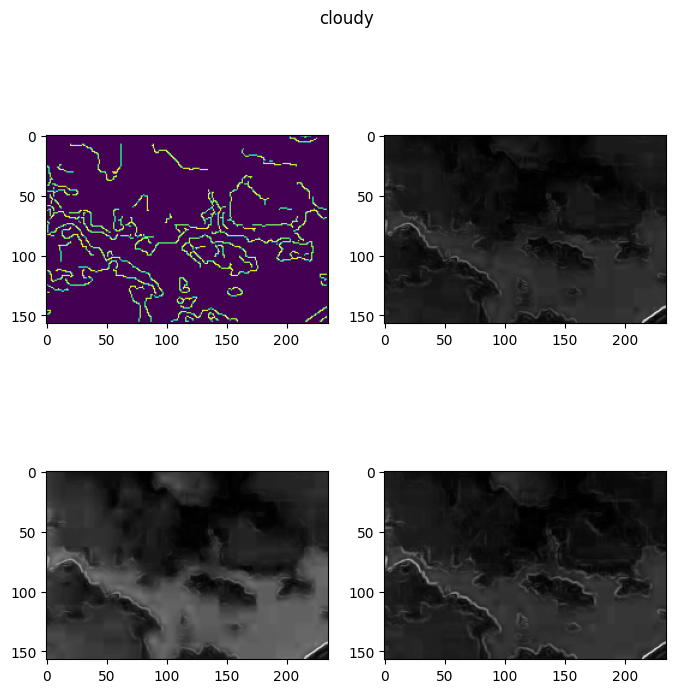

Processing image: /content/drive/My Drive/weather/rain/rain106.jpg


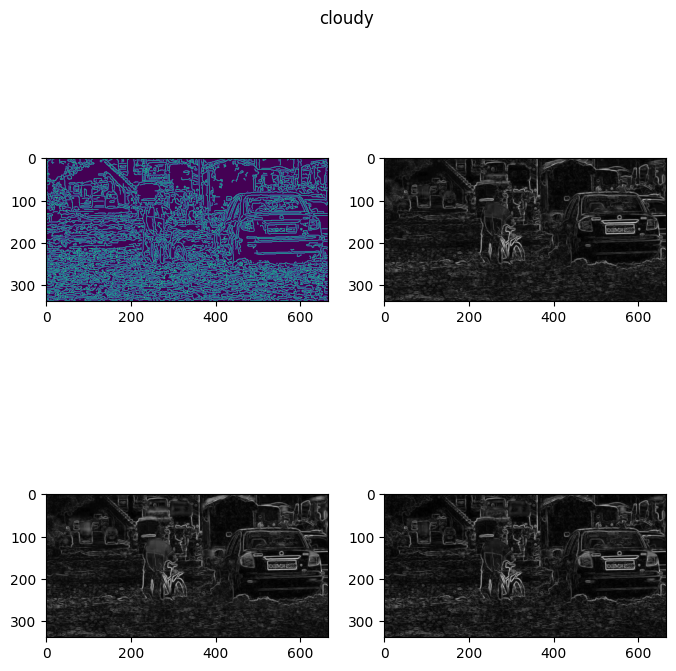

Processing image: /content/drive/My Drive/weather/sunrise/sunrise62.jpg


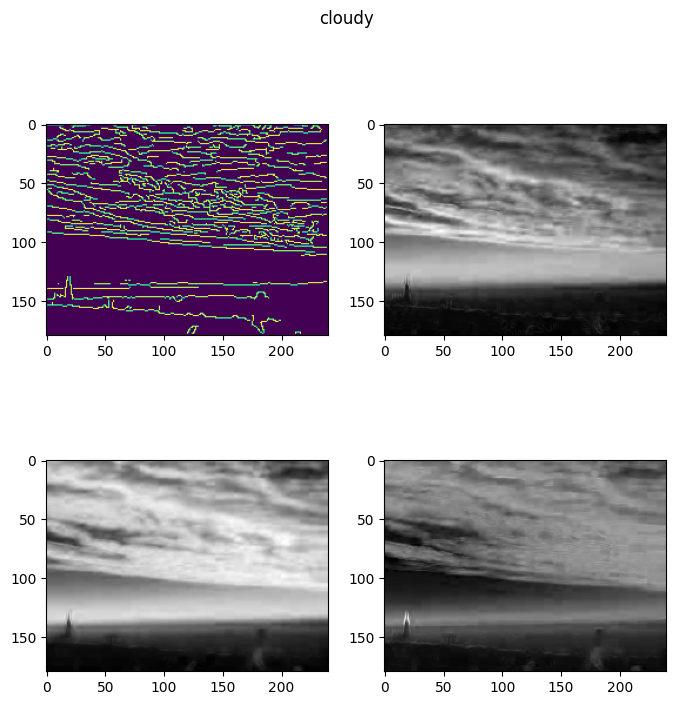

Processing image: /content/drive/My Drive/weather/cloudy/cloudy10.jpg


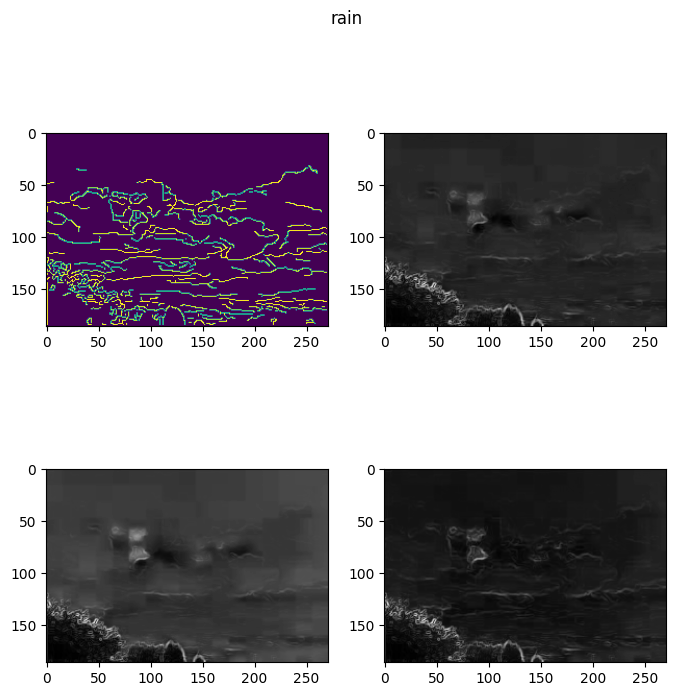

Processing image: /content/drive/My Drive/weather/sunrise/sunrise26.jpg


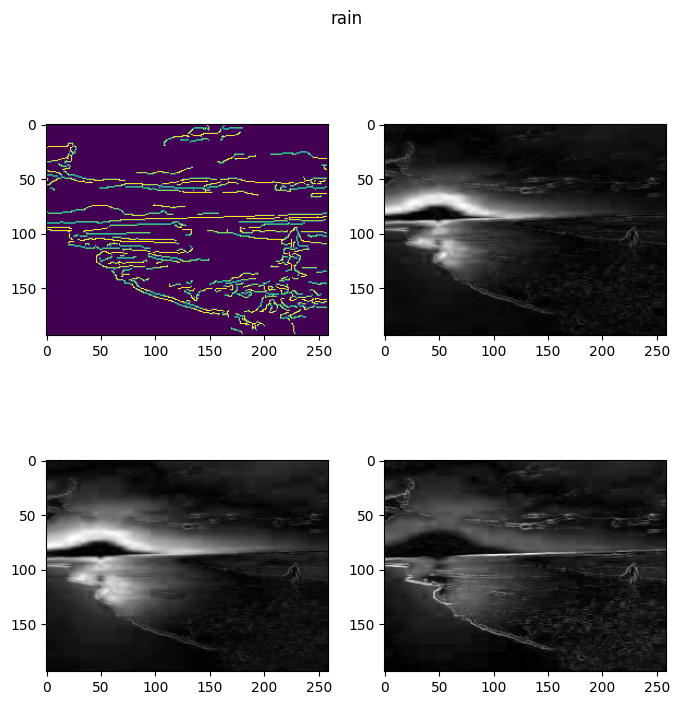

Processing image: /content/drive/My Drive/weather/cloudy/cloudy37.jpg


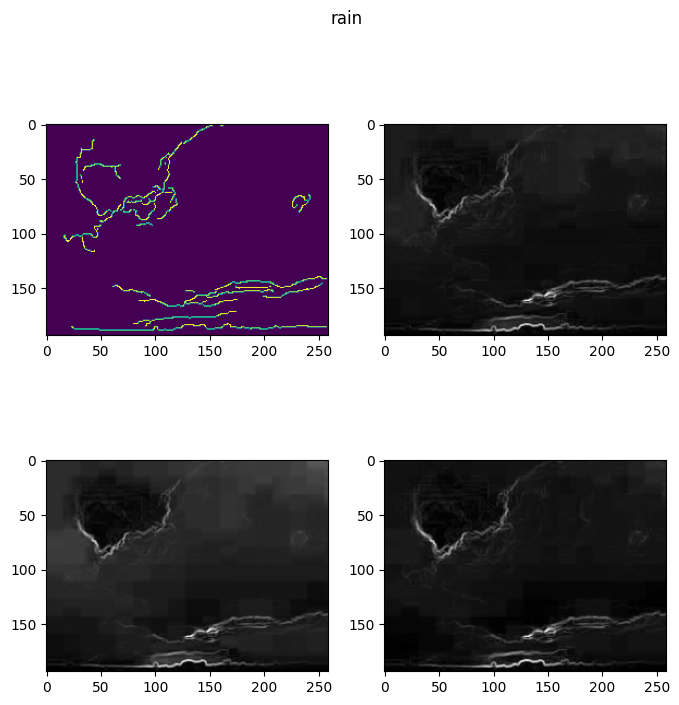

Processing image: /content/drive/My Drive/weather/shine/shine153.jpg


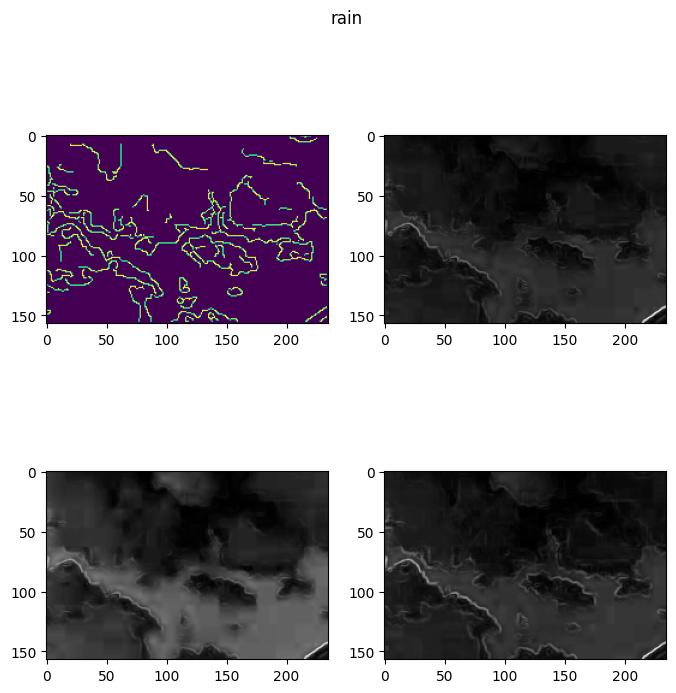

Processing image: /content/drive/My Drive/weather/sunrise/sunrise151.jpg


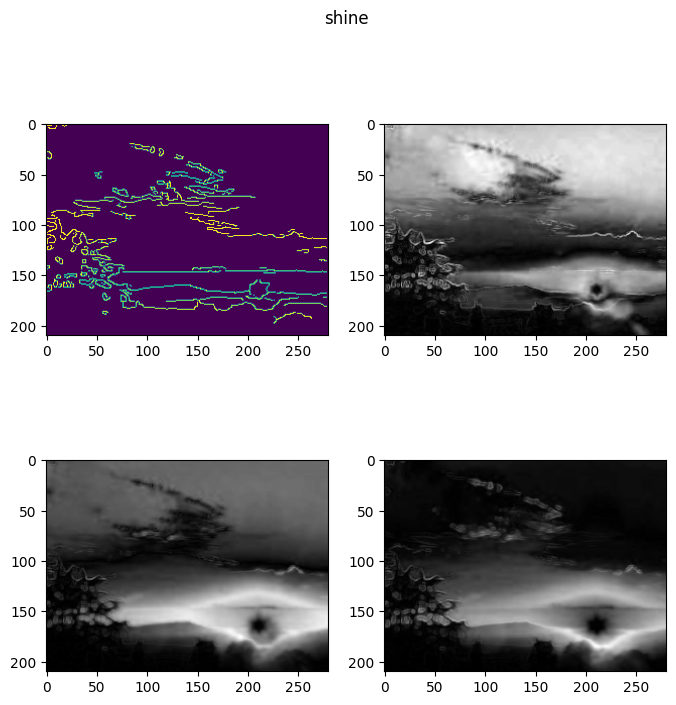

Processing image: /content/drive/My Drive/weather/cloudy/cloudy265.jpg


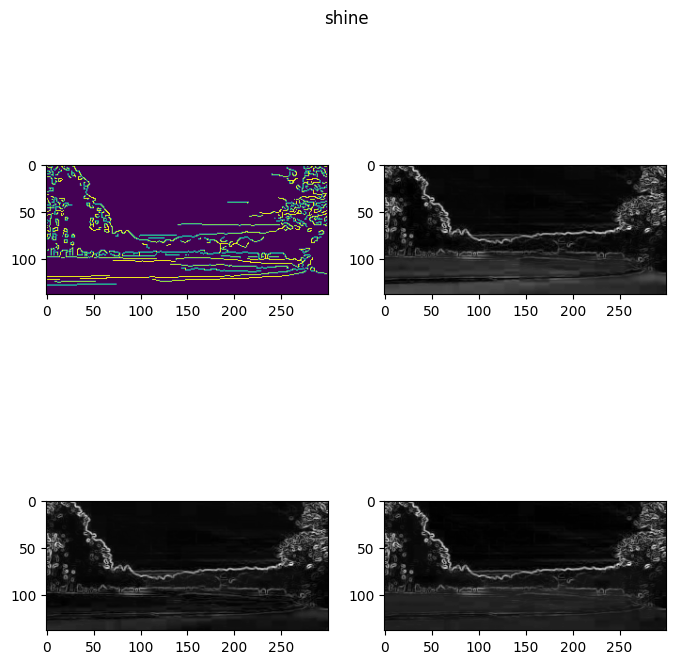

Processing image: /content/drive/My Drive/weather/shine/shine5.jpg


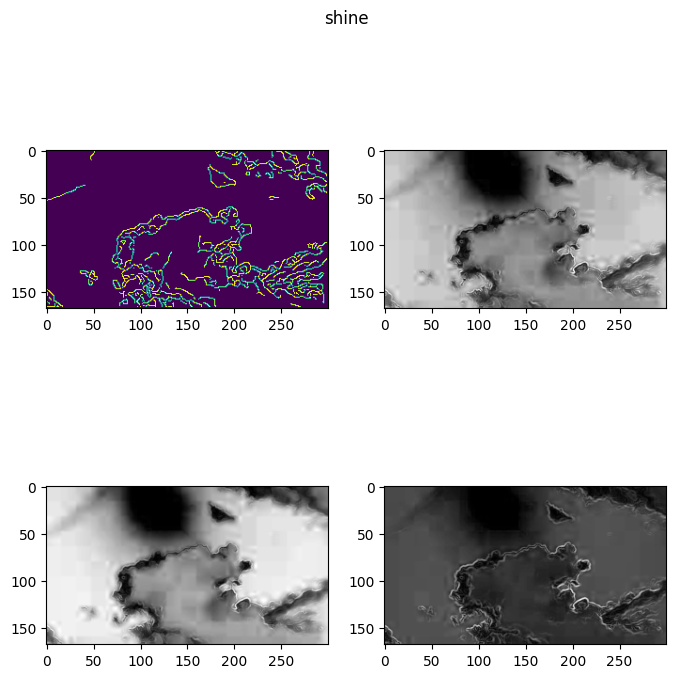

Processing image: /content/drive/My Drive/weather/sunrise/sunrise141.jpg


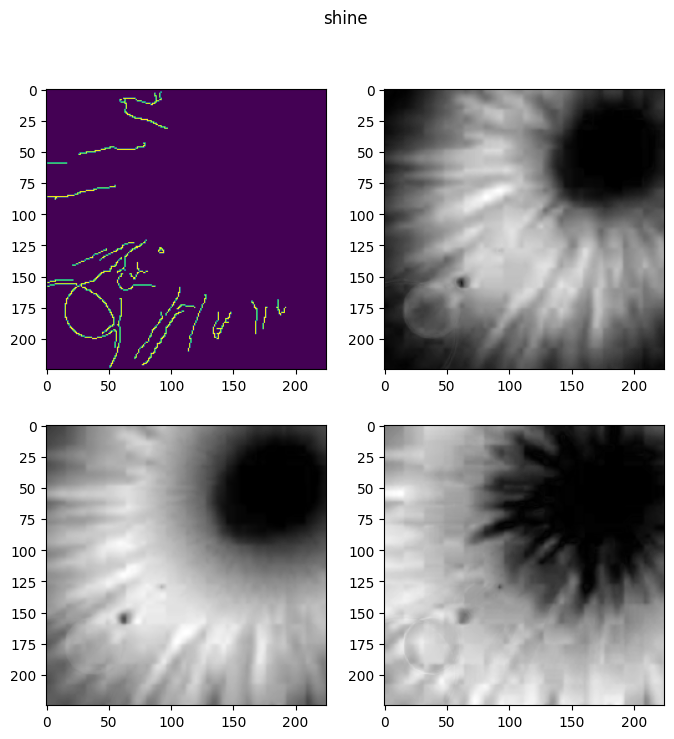

Processing image: /content/drive/My Drive/weather/shine/shine198.jpg


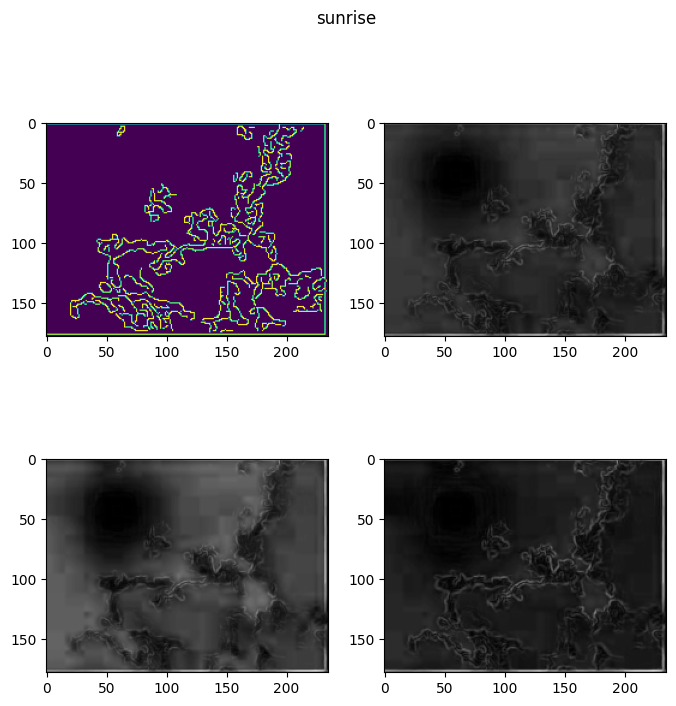

Processing image: /content/drive/My Drive/weather/sunrise/sunrise320.jpg


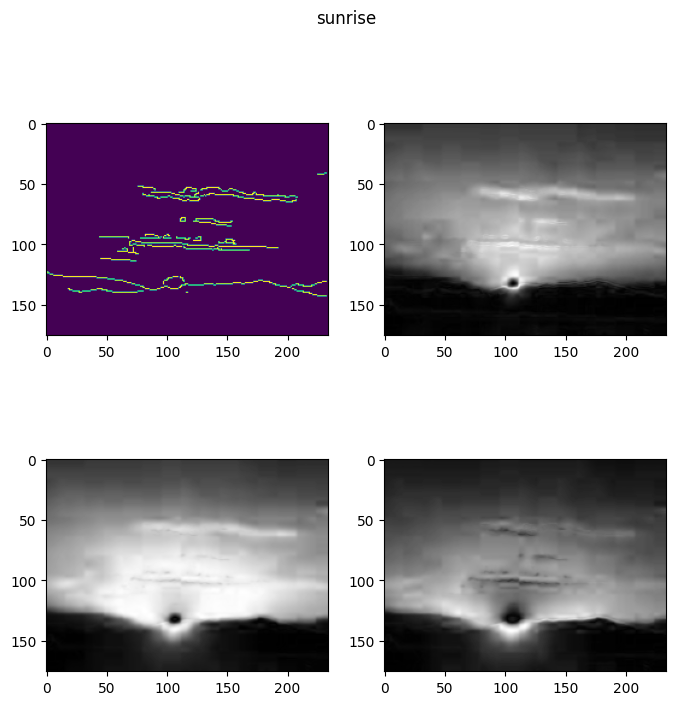

Processing image: /content/drive/My Drive/weather/rain/rain27.jpg


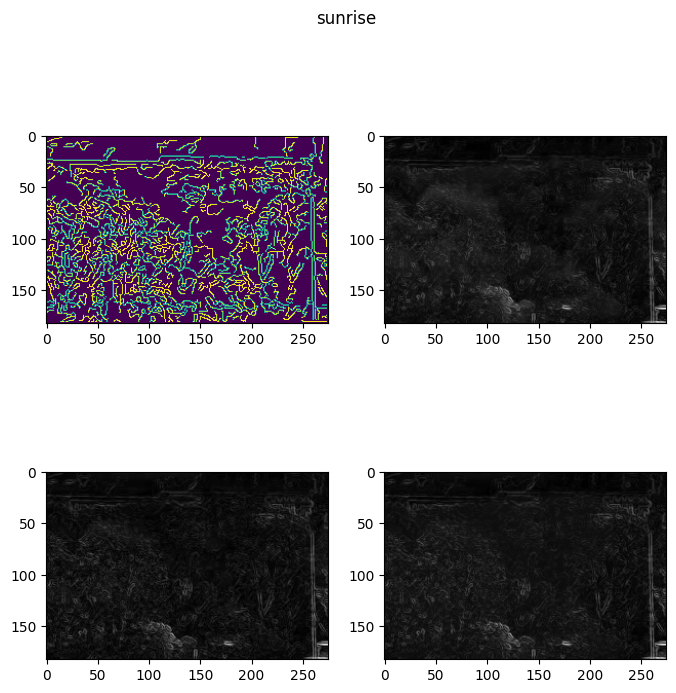

Processing image: /content/drive/My Drive/weather/sunrise/sunrise162.jpg


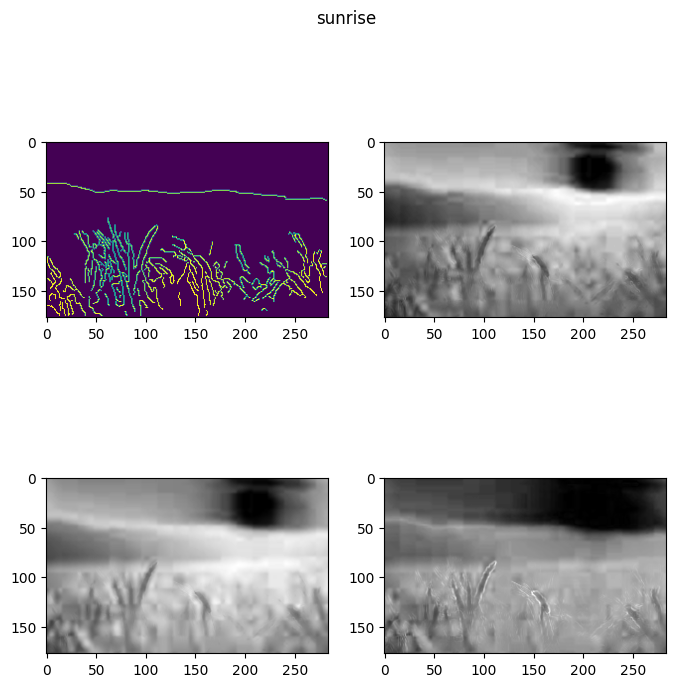

In [20]:
def edges_images_gray(class_name):
    classes_df = df[df['label'] == class_name].reset_index(drop=True)
    for idx, m in enumerate(np.random.choice(df['path'], 4)):
        print(f"Processing image: {m}")
        image = cv2.imread(m)
        if image is None:
            print(f"Error loading image: {m}")
            continue
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        edges = sobel(image)
        gray_edges = canny(gray)
        dimension = edges.shape
        fig = plt.figure(figsize=(8, 8))
        plt.suptitle(class_name)
        plt.subplot(2, 2, 1)
        plt.imshow(gray_edges)
        plt.subplot(2, 2, 2)
        plt.imshow(edges[:dimension[0], :dimension[1], 0], cmap="gray")
        plt.subplot(2, 2, 3)
        plt.imshow(edges[:dimension[0], :dimension[1], 1], cmap='gray')
        plt.subplot(2, 2, 4)
        plt.imshow(edges[:dimension[0], :dimension[1], 2], cmap='gray')
        plt.show()
for class_name in df['label'].unique():
    edges_images_gray(class_name)

# Color Analysis

In [21]:
def check_color_number(Image):
    weight = Image.size[0]
    height =Image.size[1]
    for m in range(weight):
        for n in range(height):
            r,g,b = Image.getpixel((m,n))
            if r != g != b: 
              return False
    return True

In [22]:
sampleFrac = 0.5

checkcolor_lst = []
for imageName in df['path'].sample(frac=sampleFrac):
    val = Image.open(imageName).convert('RGB')
    checkcolor_lst.append(check_color_number(val))
print(np.sum(checkcolor_lst) / len(checkcolor_lst))
del checkcolor_lst

0.030249110320284697


Since the scale value is very small, it suggests that to the range of 0 to 1, the images in the dataset have a limited range of colors. Thus, a choice of red, green and blue seems to be reasonable.

# Get the Distribution Plot for each Red, Green, and Blue color in each graph

In [23]:
def calculate_rgb_sums(row):
    image = cv2.imread(row['path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    red_sum = np.sum(image[:, :, 0])
    green_sum = np.sum(image[:, :, 1])
    blue_sum = np.sum(image[:, :, 2])
    return red_sum, green_sum, blue_sum

In [24]:
tqdm.pandas()
df[['R', 'G', 'B']] = df.progress_apply(lambda row: pd.Series(calculate_rgb_sums(row)), axis=1)

100%|██████████| 1125/1125 [00:18<00:00, 60.29it/s]


# Present the color distribution for red, green, and blue images

In [25]:
def color_distribution(df, count):
    fig, ax = plt.subplots(count, 2, figsize=(15, 15))
    
    if df.empty:
        print("The selected color has weak image intensity.")
        return
    
    for idx, path in enumerate(np.random.choice(df['path'], count)):
        image = cv2.imread(path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax[idx, 0].imshow(image_rgb)
        ax[idx, 0].axis('off')
        
        color_means = np.mean(image_rgb, axis=(0, 1))
        ax[idx, 1].set_title('R={:.0f}, G={:.0f}, B={:.0f}'.format(color_means[0], color_means[1], color_means[2]))
        
        for channel in range(3):
            histogram, bins = np.histogram(image_rgb[:, :, channel], bins=255)
            ax[idx, 1].bar(bins[:-1], histogram, label=['R', 'G', 'B'][channel], alpha=0.8, color=['red', 'green', 'blue'][channel])
        
        ax[idx, 1].legend()
        ax[idx, 1].axis('off')


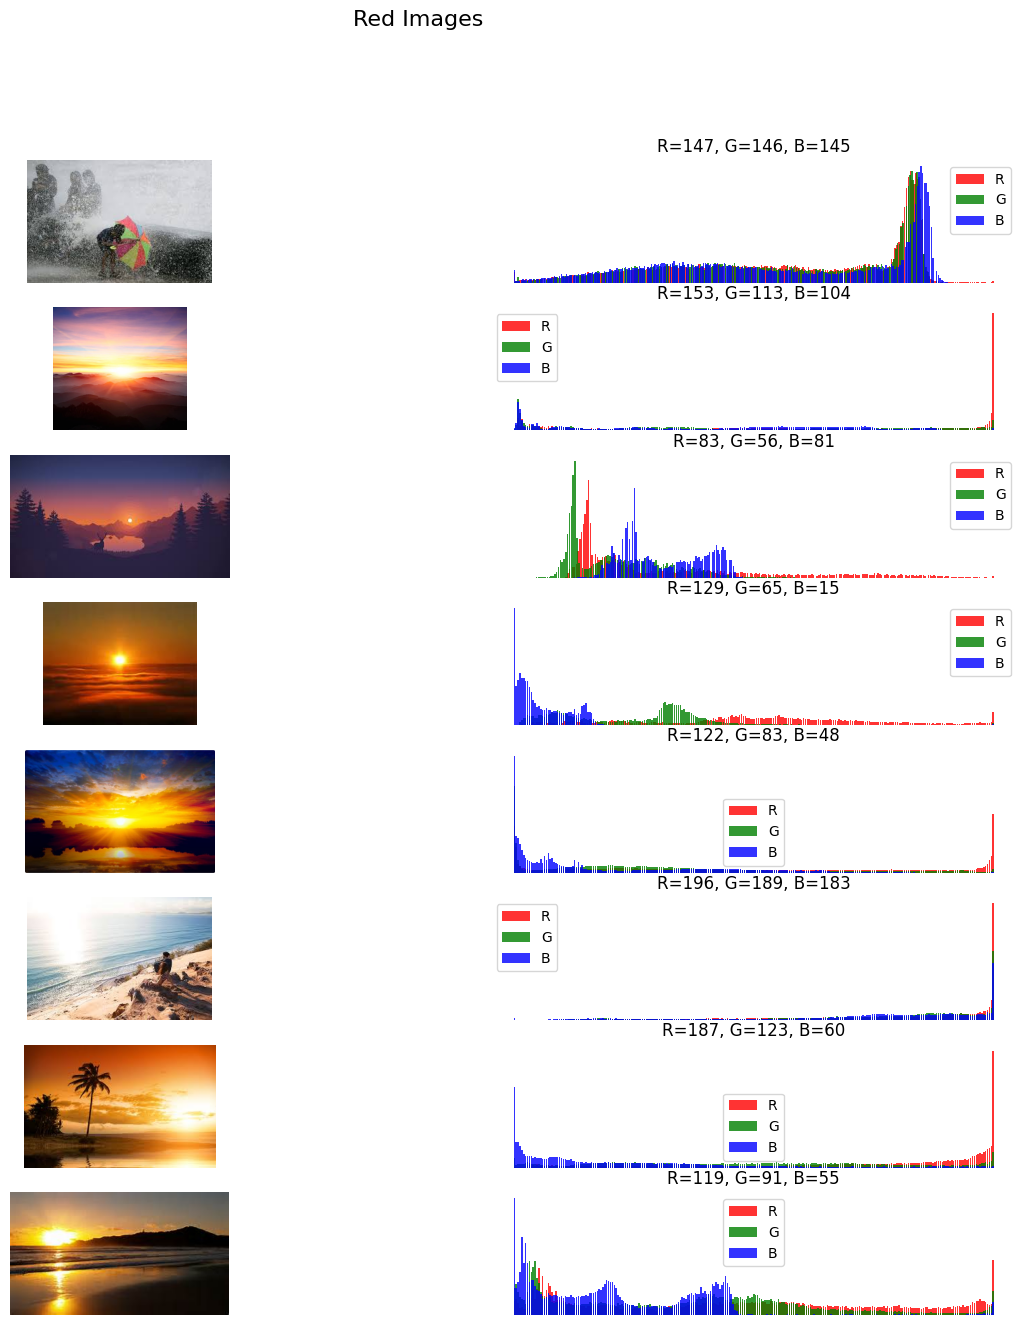

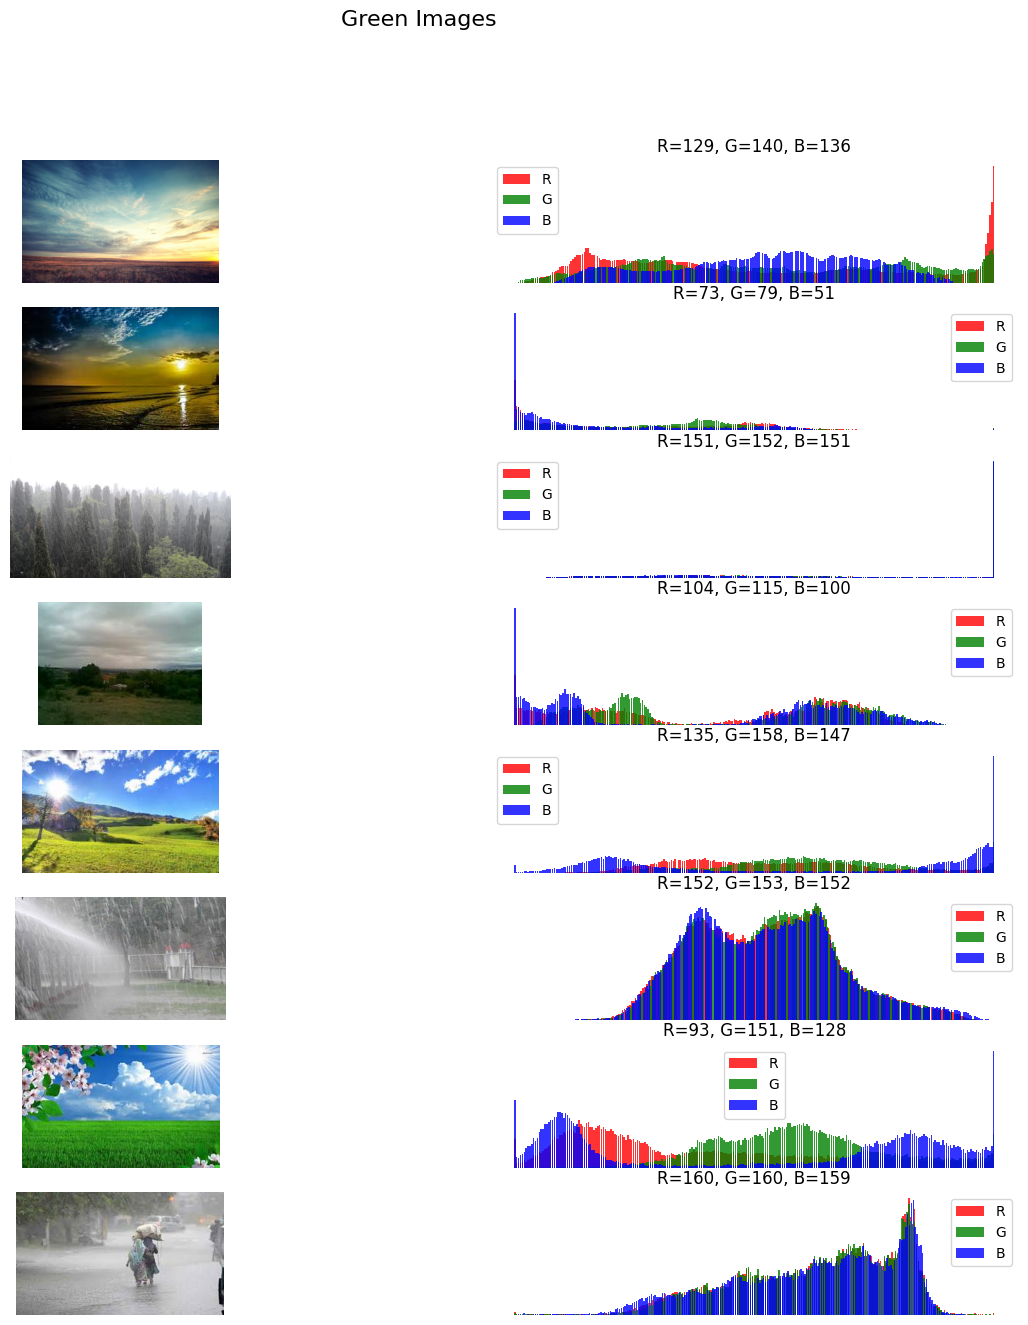

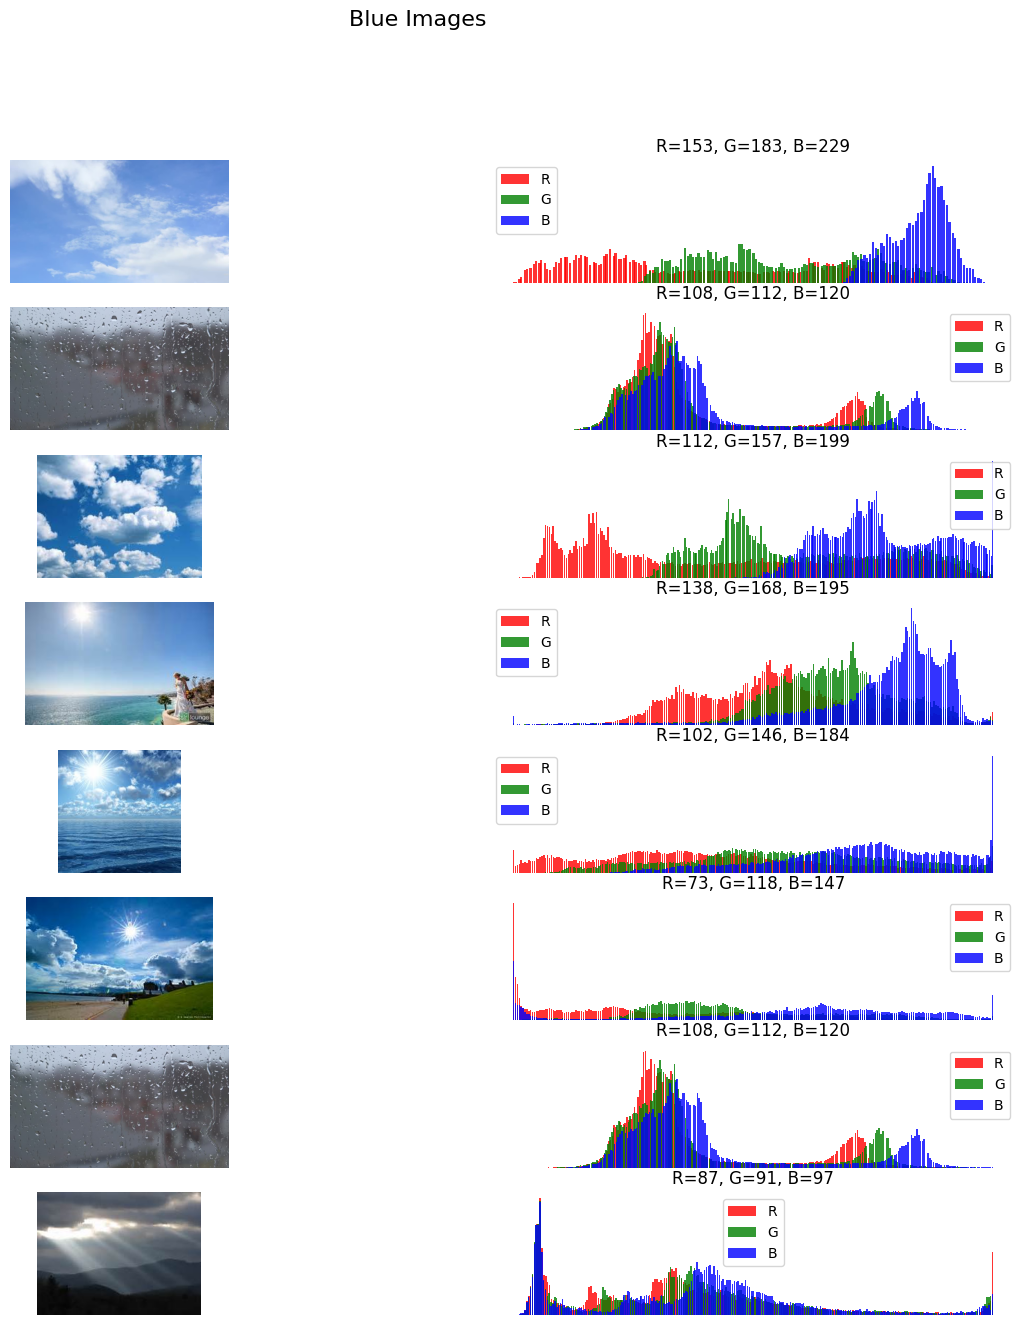

In [26]:
conditions = [
    ((df['B']) < df['R']) & ((df['G']) < df['R']),  # Condition for red images
    (df['G'] > df['R']) & (df['G'] > df['B']),     # Condition for green images
    (df['B'] > df['R']) & (df['B'] > df['G'])      # Condition for blue images
]

labels = ['Red', 'Green', 'Blue']

for condition, label in zip(conditions, labels):
    filtered_df = df[condition]
    if not filtered_df.empty:
        color_distribution(filtered_df, 8)
        plt.suptitle(f"{label} Images", fontsize=16)  # Add a title to indicate the condition
        plt.show()
    else:
        print(f"No {label} images found.")

According to the above investigation, it appears that the color distribution of the selected sample images follow the expectation of conventional understanding regarding colors.

In [27]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Starting Modelling 
Start off with using pre-trained models

In [27]:
combinations=[[5,16],[5,32],[5,64],[5,128], [10,16],[10,32],[10,64],[10,128], [20,16],[20,32],[20,64],[20,128],[50,16],[50,32],[50,64],[50,128]]

In [28]:
dir="/content/drive/My Drive/weather"

In [29]:
labels=os.listdir(dir)

In [30]:
#get image arrays and label arrays
def input_target_split(directory, labels):
    dataset = []
    stored = {}
    count = 0
    print('Labels:', labels)
    
    for label in labels:
        folder = os.path.join(directory, label)
        
        for image in os.listdir(folder):
            try:
                img_path = os.path.join(folder, image)
                img = load_img(img_path, target_size=(150, 150))
                img = img_to_array(img) / 255.0
                dataset.append((img, count))
            except:
                pass
        
        print(f'\rCompleted: {label}', end='')
        stored[label] = count
        count += 1
    
    print('Dataset length:', len(dataset))
    random.shuffle(dataset)
    X, y = zip(*dataset)
    
    

    return np.array(X), np.array(y)

In [31]:
X, y = input_target_split(dir,labels)

Labels: ['cloudy', 'shine', 'rain', 'sunrise']
Completed: sunriseDataset length: 1125


# Split the train and test set

In [32]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


In [33]:
#prepare the y values using diagnomnal matrixs
#4 for only four categories
num_labels=len(np.unique(df['label']))
y_train=np.eye(num_labels)[Y_train]
y_test=np.eye(num_labels)[Y_test]
y_val=np.eye(num_labels)[Y_val]

In [37]:
base_model=VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [38]:
for layer in base_model.layers:
    layer.trainable = False

In [39]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_labels, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
23/23 [==============================] - 17s 221ms/step - loss: 0.9679 - accuracy: 0.6139 - val_loss: 0.7278 - val_accuracy: 0.7611
Epoch 2/10
23/23 [==============================] - 2s 82ms/step - loss: 0.5589 - accuracy: 0.8125 - val_loss: 0.5739 - val_accuracy: 0.7611
Epoch 3/10
23/23 [==============================] - 2s 82ms/step - loss: 0.4327 - accuracy: 0.8542 - val_loss: 0.4438 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 2s 94ms/step - loss: 0.3282 - accuracy: 0.8903 - val_loss: 0.3931 - val_accuracy: 0.8500
Epoch 5/10
23/23 [==============================] - 2s 97ms/step - loss: 0.2784 - accuracy: 0.9139 - val_loss: 0.3503 - val_accuracy: 0.8722
Epoch 6/10
23/23 [==============================] - 2s 97ms/step - loss: 0.2404 - accuracy: 0.9278 - val_loss: 0.3255 - val_accuracy: 0.8944
Epoch 7/10
23/23 [==============================] - 2s 94ms/step - loss: 0.2083 - accuracy: 0.9347 - val_loss: 0.3230 - val_accuracy: 0.8667
Epoch 8/10


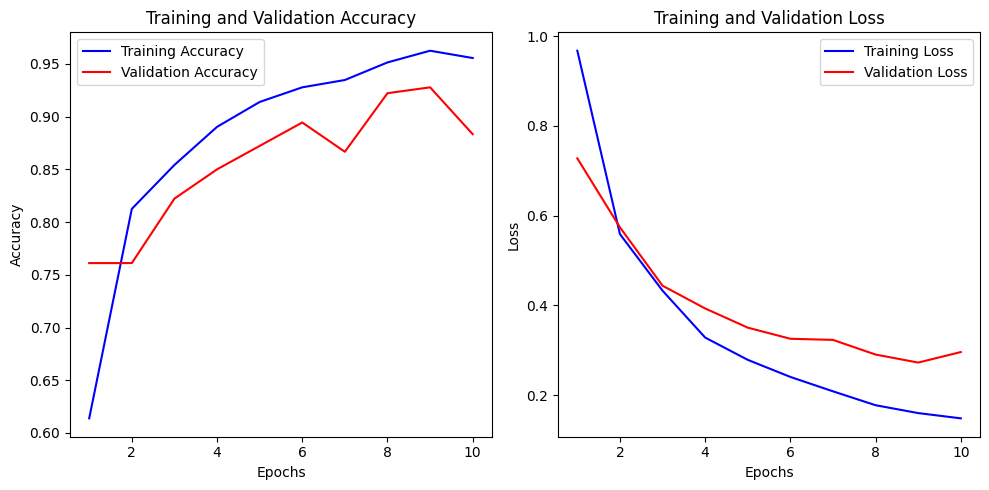

In [41]:
import matplotlib.pyplot as plt

# Get the accuracy and loss values from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Apply this particular model on the test set

In [42]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compare predicted labels with true labels
accuracy = np.mean(predicted_labels == Y_test)
print("Test set accuracy:", accuracy)


8/8 [==============================] - 1s 132ms/step
Test set accuracy: 0.8977777777777778


Though the accuracy and loss in both training and validation deviate from each other, in general, they both exhibit similar tendency as epochs rises, i.e. Accuracy improves and loss decreases when epochs increases. However, it can be only the special case for this particular model with this particular combinations. And it also appears that the test set has relatively great accuracy. Therefore it is worth to try out different combinations of epoch and batch sizes to fully determine if this model architecture would yield overfitting/underfitting problems and to see if a regularization technique would be needed.

# Try more combinations of Epochs and Batch Sizes into the same model architecture

In [43]:
#write a function for modelling
def base_vgg_16_modelling(X,y,df,epochs,batch_size):
  X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

  num_labels=len(np.unique(df['label']))
  y_train=np.eye(num_labels)[Y_train]
  y_test=np.eye(num_labels)[Y_test]
  y_val=np.eye(num_labels)[Y_val]

  #initialize the base model
# Build the model architecture
  base_model=VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3))
  for layer in base_model.layers:
    layer.trainable = False
  
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(512, activation='relu')(x)
  predictions = Dense(num_labels, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions) 
# Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

  training_accuracy = history.history['accuracy']
  training_loss = history.history['loss']
  validation_accuracy = history.history['val_accuracy']
  validation_loss = history.history['val_loss']

  test_predictions = model.predict(X_test)
  predicted_labels = np.argmax(test_predictions, axis=1)

# Compare predicted labels with true labels
  accuracy = np.mean(predicted_labels == Y_test)
  #test_loss, test_accuracy=model.evaluate(X_test,Y_test, batch_size=batch_size)
  return training_accuracy, training_loss, validation_accuracy, validation_loss, accuracy

In [40]:
combinations=[[5,16],[5,32],[5,64],[5,128], [10,16],[10,32],[10,64],[10,128], [20,16],[20,32],[20,64],[20,128],[50,16],[50,32],[50,64],[50,128]]

In [45]:
arry=np.zeros((16,7))

In [46]:
for m in range(len(combinations)):
  arry[m][0]=combinations[m][0]
  arry[m][1]=combinations[m][1]
  preliminary_model_output=list(base_vgg_16_modelling(X,y,df,combinations[m][0],combinations[m][1]))
  arry[m][2]=np.mean(preliminary_model_output[0])
  arry[m][3]=np.mean(preliminary_model_output[1])
  arry[m][4]=np.mean(preliminary_model_output[2])
  arry[m][5]=np.mean(preliminary_model_output[3])
  arry[m][6]=preliminary_model_output[4]
  #arry[m][7]=preliminary_model_output[5]

Epoch 1/5
45/45 [==============================] - 4s 72ms/step - loss: 0.8741 - accuracy: 0.6694 - val_loss: 0.5839 - val_accuracy: 0.7944
Epoch 2/5
45/45 [==============================] - 2s 52ms/step - loss: 0.4472 - accuracy: 0.8514 - val_loss: 0.4773 - val_accuracy: 0.8278
Epoch 3/5
45/45 [==============================] - 2s 51ms/step - loss: 0.3474 - accuracy: 0.8819 - val_loss: 0.4393 - val_accuracy: 0.8667
Epoch 4/5
45/45 [==============================] - 2s 51ms/step - loss: 0.2766 - accuracy: 0.9097 - val_loss: 0.3606 - val_accuracy: 0.8500
Epoch 5/5
8/8 [==============================] - 1s 68ms/step
Epoch 1/5
23/23 [==============================] - 3s 100ms/step - loss: 0.9867 - accuracy: 0.6083 - val_loss: 0.6759 - val_accuracy: 0.7556
Epoch 2/5
23/23 [==============================] - 2s 94ms/step - loss: 0.5464 - accuracy: 0.8278 - val_loss: 0.5090 - val_accuracy: 0.8000
Epoch 3/5
23/23 [==============================] - 2s 94ms/step - loss: 0.4101 - accuracy: 0.8639

In [47]:
output_for_evaluation=pd.DataFrame(arry,columns=['Epochs','Batch Size', 'Training_accuracy', 'Training_loss', 'Validation_accuracy', 'Validation_loss', 'Accuracy'])
output_for_evaluation

Epochs  Batch Size  Training_accuracy  Training_loss  Validation_accuracy  \
0      5.0        16.0           0.850556       0.431194             0.853333   
1      5.0        32.0           0.822222       0.509676             0.817778   
2      5.0        64.0           0.781389       0.631091             0.787778   
3      5.0       128.0           0.731944       0.766506             0.756667   
4     10.0        16.0           0.902222       0.294061             0.866667   
5     10.0        32.0           0.877778       0.358006             0.860000   
6     10.0        64.0           0.833333       0.460020             0.828333   
7     10.0       128.0           0.809583       0.557774             0.782222   
8     20.0        16.0           0.951389       0.161430             0.903611   
9     20.0        32.0           0.925764       0.231237             0.877778   
10    20.0        64.0           0.905694       0.297759             0.856667   
11    20.0       128.0           0.870694       0.392833             0.832778   
12    50.0        16.0           0.977194       0.079492             0.909000   
13    50.0        32.0           0.970278       0.106160             0.903000   
14    50.0        64.0           0.956611       0.151825             0.896889   
15    50.0       128.0           0.941611       0.201187             0.882222   

    Validation_loss  Accuracy  
0          0.436082  0.906667  
1          0.481075  0.893333  
2          0.598430  0.888889  
3          0.694303  0.857778  
4          0.349559  0.933333  
5          0.394937  0.893333  
6          0.473029  0.893333  
7          0.567088  0.888889  
8          0.277583  0.915556  
9          0.335412  0.911111  
10         0.379958  0.928889  
11         0.446839  0.915556  
12         0.268689  0.928889  
13         0.268711  0.920000  
14         0.287919  0.924444  
15         0.315065  0.928889

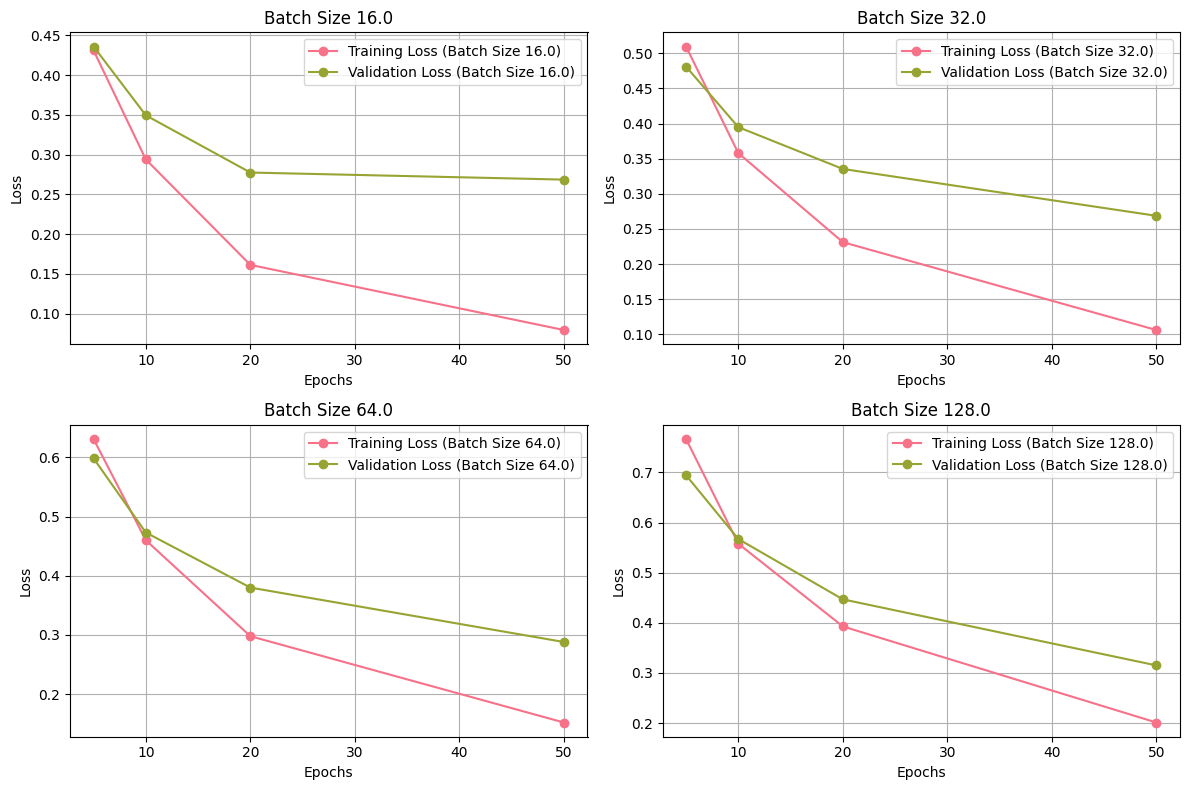

In [48]:
import matplotlib.pyplot as plt

# Extract the data for visualization
base_epochs = output_for_evaluation['Epochs']
base_batch_sizes = output_for_evaluation['Batch Size']
base_training_loss = output_for_evaluation['Training_loss']
base_validation_loss = output_for_evaluation['Validation_loss']

# Group the data by batch size
batch_sizes = set(base_batch_sizes)
grouped_data = {}
for batch_size in batch_sizes:
    idx = base_batch_sizes == batch_size
    grouped_data[batch_size] = {
        'epochs': base_epochs[idx],
        'training_loss': base_training_loss[idx],
        'validation_loss': base_validation_loss[idx]
    }

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for m, (batch_size, data) in enumerate(grouped_data.items()):
    ax = axes[m]
    ax.plot(data['epochs'], data['training_loss'], marker='o', label=f'Training Loss (Batch Size {batch_size})')
    ax.plot(data['epochs'], data['validation_loss'], marker='o', label=f'Validation Loss (Batch Size {batch_size})')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Batch Size {batch_size}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


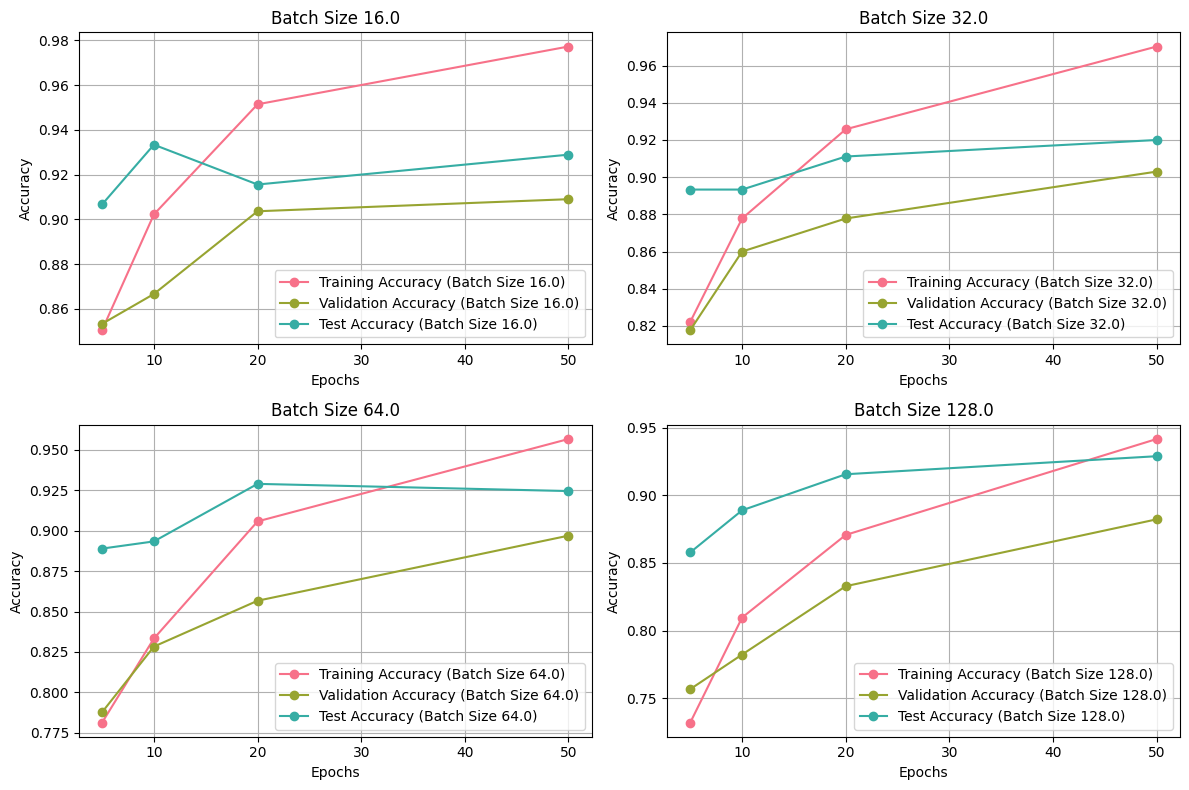

In [49]:
import matplotlib.pyplot as plt

# Extract the data for visualization
base_epochs = output_for_evaluation['Epochs']
base_batch_sizes = output_for_evaluation['Batch Size']
base_training_accuracy = output_for_evaluation['Training_accuracy']
base_validation_accuracy = output_for_evaluation['Validation_accuracy']
base_test_accuracy = output_for_evaluation['Accuracy']

# Group the data by batch size
batch_sizes = set(base_batch_sizes)
grouped_data = {}
for batch_size in batch_sizes:
    idx = base_batch_sizes == batch_size
    grouped_data[batch_size] = {
        'epochs': base_epochs[idx],
        'training_accuracy': base_training_accuracy[idx],
        'validation_accuracy': base_validation_accuracy[idx],
        'test_accuracy': base_test_accuracy[idx]
    }

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for m, (batch_size, data) in enumerate(grouped_data.items()):
    ax = axes[m]
    ax.plot(data['epochs'], data['training_accuracy'], marker='o', label=f'Training Accuracy (Batch Size {batch_size})')
    ax.plot(data['epochs'], data['validation_accuracy'], marker='o', label=f'Validation Accuracy (Batch Size {batch_size})')
    ax.plot(data['epochs'], data['test_accuracy'], marker='o', label=f'Test Accuracy (Batch Size {batch_size})')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Batch Size {batch_size}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()



**Batch Size** = 16:

**Observation**  
**Training Accuracy**: Higher than validation accuracy from the beginning. Rapidly increases as epochs increase.  
**Validation Accuracy**: Slight increases.  
**Test Accuracy**: Slight increases.   

**Interpretation:** This behavior suggests that the model may be overfitting to the training data. The initial higher training accuracy indicates that the model is able to fit well to the training data. However, as the number of epochs increases, the model starts to memorize the training samples and becomes too specialized, resulting in a minized increase in validation and test accuracies. The validation and test accuracies indicate that the model's ability to generalize to unseen data diminishes over time. This overfitting behavior could be an indication that the model is too complex.

**Batch Size** = 32:

**Observation**  
**Training Accuracy**: Higher than validation accuracy from the beginning. Rapidly increases as epochs increase.   
**Validation Accuracy**: Increases.   
**Test Accuracy**: Slight increases.   

**Interpretation:** Similar to Batch Size = 16, this behavior suggests that the model may be overfitting to the training data. The higher training accuracy from the beginning indicates that the model is able to fit well to the training data. However, as the number of epochs increases, the model starts to overfit and its performance on unseen validation and test data decreases. This could be an indication that the model is too complex.

**Batch Size** = 64:

**Observation**   
**Training Accuracy**: Higher than validation accuracy from the beginning. Rapidly increases as epochs increase.   
**Validation Accuracy**: Increases.   
**Test Accuracy**: Decreases.  

**Interpretation:** Similar to Batch Sizes 16 and 32, this behavior suggests that the model may be overfitting to the training data. The higher training accuracy from the beginning indicates that the model is able to fit well to the training data. However, as the number of epochs increases, the model starts to overfit and its performance on unseen validation and test data decreases.

**Batch Size** = 128:

**Observation**   
**Training Accuracy**: Higher than validation accuracy from the beginning. Rapidly increases as epochs increase.   
**Validation Accuracy**: Increases.  
**Test Accuracy**: Slight increases.   

**Interpretation:** Similar to Batch Sizes 16, 32, and 64, this behavior suggests that the model may be overfitting to the training data. The higher training accuracy from the beginning indicates that the model is able to fit well to the training data. However, as the number of epochs increases, the model starts to overfit and its performance on unseen validation and test data decreases.

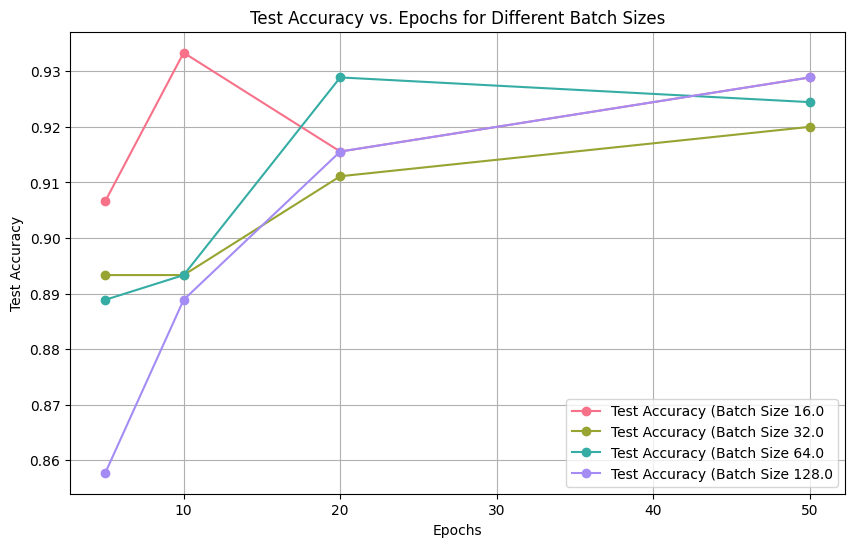

In [50]:
import matplotlib.pyplot as plt

# Extract the data for visualization
base_epochs = output_for_evaluation['Epochs']
base_batch_sizes = output_for_evaluation['Batch Size']
base_test_accuracy = output_for_evaluation['Accuracy']

# Group the data by batch size
batch_sizes = set(base_batch_sizes)
grouped_data = {}
for batch_size in batch_sizes:
    idx = base_batch_sizes == batch_size
    grouped_data[batch_size] = {
        'epochs': base_epochs[idx],
        'test_accuracy': base_test_accuracy[idx]
    }

# Create the plot
plt.figure(figsize=(10, 6))

for batch_size, data in grouped_data.items():
    plt.plot(data['epochs'], data['test_accuracy'], marker='o', label=f'Test Accuracy (Batch Size {batch_size}')

plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Epochs for Different Batch Sizes')
plt.legend()
plt.grid(True)
plt.show()


#Discussion
The above plots indicates several interesting phenomenons.



First, from the plots regarding accuracy, loss from the training and validation set, it might well indicate a potential issue of overfitting at almost every combination of batch and epoches. 

In addition, though the test accurracy still looks great for until epoch=50, it is still worthy to note its potential diminishing trend as epoch increases further. 

Therefore, with the observations in mind, in appears that, regardless of the batch size and epochs numbers, the base model in general is overfitting , where it fits the model too well and captures excessive complexities and nuances present in the data, starting to lead to a capture of excessive complex relationship within the training examples, as the training accuracy is almost larger than the testing accuracy

Some techniques can be implemented here in this case: 
1. Increase training samples 
2. Regularization
3. Early Stopping

# Write Some necessary functions that help for automation of modellings

In [36]:
def get_outputs(combinations,X,y,modelling,df):
  arry=np.zeros((len(combinations),7))
  for m in range(len(combinations)):
    arry[m][0]=combinations[m][0]
    arry[m][1]=combinations[m][1]
    preliminary_model_output=list(modelling(X,y,df,combinations[m][0],combinations[m][1]))
    arry[m][2]=np.mean(preliminary_model_output[0])
    arry[m][3]=np.mean(preliminary_model_output[1])
    arry[m][4]=np.mean(preliminary_model_output[2])
    arry[m][5]=np.mean(preliminary_model_output[3])
    arry[m][6]=preliminary_model_output[4]
  
  output_for_evaluation=pd.DataFrame(arry,columns=['Epochs','Batch Size', 'Training_accuracy', 'Training_loss', 'Validation_accuracy', 'Validation_loss', 'Accuracy'])
  return output_for_evaluation

In [37]:
import matplotlib.pyplot as plt
def plot_loss(output_for_evaluation):
  base_epochs = output_for_evaluation['Epochs']
  base_batch_sizes = output_for_evaluation['Batch Size']
  base_training_loss = output_for_evaluation['Training_loss']
  base_validation_loss = output_for_evaluation['Validation_loss']
  
  batch_sizes = set(base_batch_sizes)
  grouped_data = {}
  for batch_size in batch_sizes:
    idx = base_batch_sizes == batch_size
    grouped_data[batch_size] = {
        'epochs': base_epochs[idx],
        'training_loss': base_training_loss[idx],
        'validation_loss': base_validation_loss[idx]
    }

# Create subplots
  fig, axes = plt.subplots(2, 2, figsize=(12, 8))
  axes = axes.flatten()

  for m, (batch_size, data) in enumerate(grouped_data.items()):
    ax = axes[m]
    ax.plot(data['epochs'], data['training_loss'], marker='o', label=f'Training Loss (Batch Size {batch_size})')
    ax.plot(data['epochs'], data['validation_loss'], marker='o', label=f'Validation Loss (Batch Size {batch_size})')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Batch Size {batch_size}')
    ax.legend()
    ax.grid(True)

  plt.tight_layout()
  plt.show()

In [38]:
import matplotlib.pyplot as plt
def plot_accuracy(output_for_evaluation):
  base_epochs = output_for_evaluation['Epochs']
  base_batch_sizes = output_for_evaluation['Batch Size']
  base_training_accuracy = output_for_evaluation['Training_accuracy']
  base_validation_accuracy = output_for_evaluation['Validation_accuracy']
  base_test_accuracy = output_for_evaluation['Accuracy']
  
  batch_sizes = set(base_batch_sizes)
  grouped_data = {}
  for batch_size in batch_sizes:
    idx = base_batch_sizes == batch_size
    grouped_data[batch_size] = {
        'epochs': base_epochs[idx],
        'training_accuracy': base_training_accuracy[idx],
        'validation_accuracy': base_validation_accuracy[idx],
        'test_accuracy': base_test_accuracy[idx]
    }

  fig, axes = plt.subplots(2, 2, figsize=(12, 8))
  axes = axes.flatten()

  for m, (batch_size, data) in enumerate(grouped_data.items()):
    ax = axes[m]
    ax.plot(data['epochs'], data['training_accuracy'], marker='o', label=f'Training Accuracy (Batch Size {batch_size})')
    ax.plot(data['epochs'], data['validation_accuracy'], marker='o', label=f'Validation Accuracy (Batch Size {batch_size})')
    ax.plot(data['epochs'], data['test_accuracy'], marker='o', label=f'Test Accuracy (Batch Size {batch_size})')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Batch Size {batch_size}')
    ax.legend()
    ax.grid(True)

  plt.tight_layout()
  plt.show()

In [39]:
import matplotlib.pyplot as plt

# Extract the data for visualization
def plot_test_accuracy(output_for_evaluation):
  base_epochs = output_for_evaluation['Epochs']
  base_batch_sizes = output_for_evaluation['Batch Size']
  base_test_accuracy = output_for_evaluation['Accuracy']

# Group the data by batch size
  batch_sizes = set(base_batch_sizes)
  grouped_data = {}
  for batch_size in batch_sizes:
    idx = base_batch_sizes == batch_size
    grouped_data[batch_size] = {
        'epochs': base_epochs[idx],
        'test_accuracy': base_test_accuracy[idx]
    }

# Create the plot
  plt.figure(figsize=(10, 6))
  for batch_size, data in grouped_data.items():
    plt.plot(data['epochs'], data['test_accuracy'], marker='o', label=f'Test Accuracy (Batch Size {batch_size}')

  plt.xlabel('Epochs')
  plt.ylabel('Test Accuracy')
  plt.title('Test Accuracy vs. Epochs for Different Batch Sizes')
  plt.legend()
  plt.grid(True)
  plt.show()

# Enhanced Models with Data Augmentation, Regularization, and Early Stopping techniques

In [64]:
from tensorflow.keras.layers import Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def enhanced_vgg_16_modelling(X, y, df, epochs, batch_size):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

    num_labels = len(np.unique(df['label']))
    y_train = np.eye(num_labels)[Y_train]
    y_test = np.eye(num_labels)[Y_test]
    y_val = np.eye(num_labels)[Y_val]

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    train_datagen.fit(X_train)

    # Initialize the base model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # Adding L2 regularization
    x = Dropout(0.5)(x)  # Adding Dropout layer
    predictions = Dense(num_labels, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model with augmented data
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stop]
    )

    training_accuracy = history.history['accuracy']
    training_loss = history.history['loss']
    validation_accuracy = history.history['val_accuracy']
    validation_loss = history.history['val_loss']

    test_predictions = model.predict(X_test)
    predicted_labels = np.argmax(test_predictions, axis=1)
    accuracy = np.mean(predicted_labels == Y_test)

    return training_accuracy, training_loss, validation_accuracy, validation_loss, accuracy



In [65]:
enhanced_model_output=get_outputs(combinations,X,y,enhanced_vgg_16_modelling, df)

Epoch 1/5
45/45 [==============================] - 7s 126ms/step - loss: 1.4423 - accuracy: 0.5292 - val_loss: 1.0219 - val_accuracy: 0.6944
Epoch 2/5
45/45 [==============================] - 4s 99ms/step - loss: 0.8401 - accuracy: 0.7778 - val_loss: 0.7325 - val_accuracy: 0.8167
Epoch 3/5
45/45 [==============================] - 6s 124ms/step - loss: 0.7139 - accuracy: 0.8167 - val_loss: 0.6577 - val_accuracy: 0.8333
Epoch 4/5
45/45 [==============================] - 4s 99ms/step - loss: 0.6180 - accuracy: 0.8431 - val_loss: 0.6075 - val_accuracy: 0.8333
Epoch 5/5
8/8 [==============================] - 1s 62ms/step
Epoch 1/5
23/23 [==============================] - 8s 274ms/step - loss: 1.5723 - accuracy: 0.5069 - val_loss: 1.1416 - val_accuracy: 0.7333
Epoch 2/5
23/23 [==============================] - 5s 233ms/step - loss: 1.0055 - accuracy: 0.7528 - val_loss: 0.8652 - val_accuracy: 0.7778
Epoch 3/5
23/23 [==============================] - 4s 182ms/step - loss: 0.8177 - accuracy: 0.

In [72]:
enhanced_model_output

Epochs  Batch Size  Training_accuracy  Training_loss  Validation_accuracy  \
0      5.0        16.0           0.763611       0.834489             0.810000   
1      5.0        32.0           0.739722       0.948827             0.796667   
2      5.0        64.0           0.680556       1.127381             0.752222   
3      5.0       128.0           0.638333       1.284378             0.751111   
4     10.0        16.0           0.824583       0.652155             0.836667   
5     10.0        32.0           0.805278       0.722179             0.830000   
6     10.0        64.0           0.772500       0.853420             0.802778   
7     10.0       128.0           0.734583       1.005421             0.778889   
8     20.0        16.0           0.864043       0.529002             0.879938   
9     20.0        32.0           0.851736       0.565784             0.859722   
10    20.0        64.0           0.838889       0.644760             0.847778   
11    20.0       128.0           0.817917       0.741925             0.833889   
12    50.0        16.0           0.877556       0.478096             0.892444   
13    50.0        32.0           0.838426       0.626169             0.860000   
14    50.0        64.0           0.852932       0.590036             0.856790   
15    50.0       128.0           0.871417       0.532475             0.883333   

    Validation_loss  Accuracy  
0          0.716021  0.871111  
1          0.811043  0.862222  
2          0.973996  0.831111  
3          1.120132  0.831111  
4          0.601817  0.911111  
5          0.654685  0.911111  
6          0.776609  0.888889  
7          0.939212  0.862222  
8          0.508344  0.915556  
9          0.551068  0.911111  
10         0.624524  0.920000  
11         0.713309  0.906667  
12         0.459732  0.928889  
13         0.593647  0.911111  
14         0.582132  0.902222  
15         0.539265  0.937778

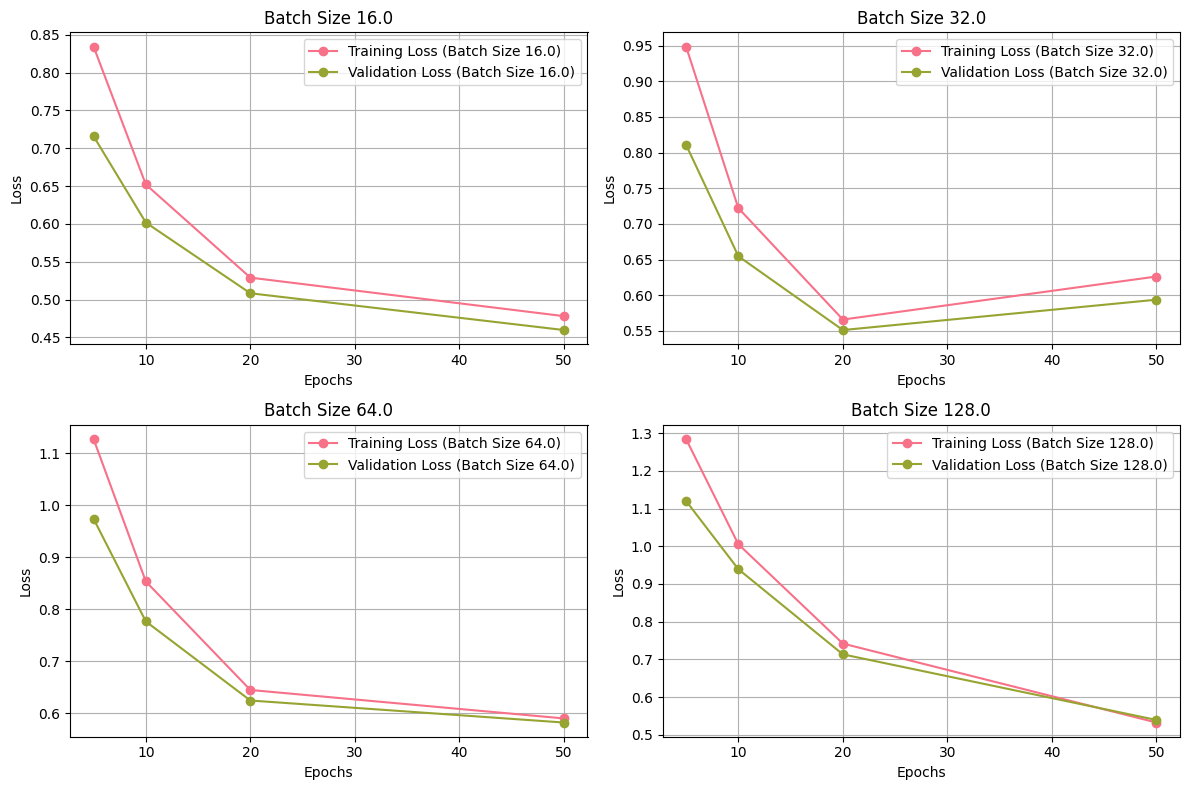

In [73]:
plot_loss(enhanced_model_output)

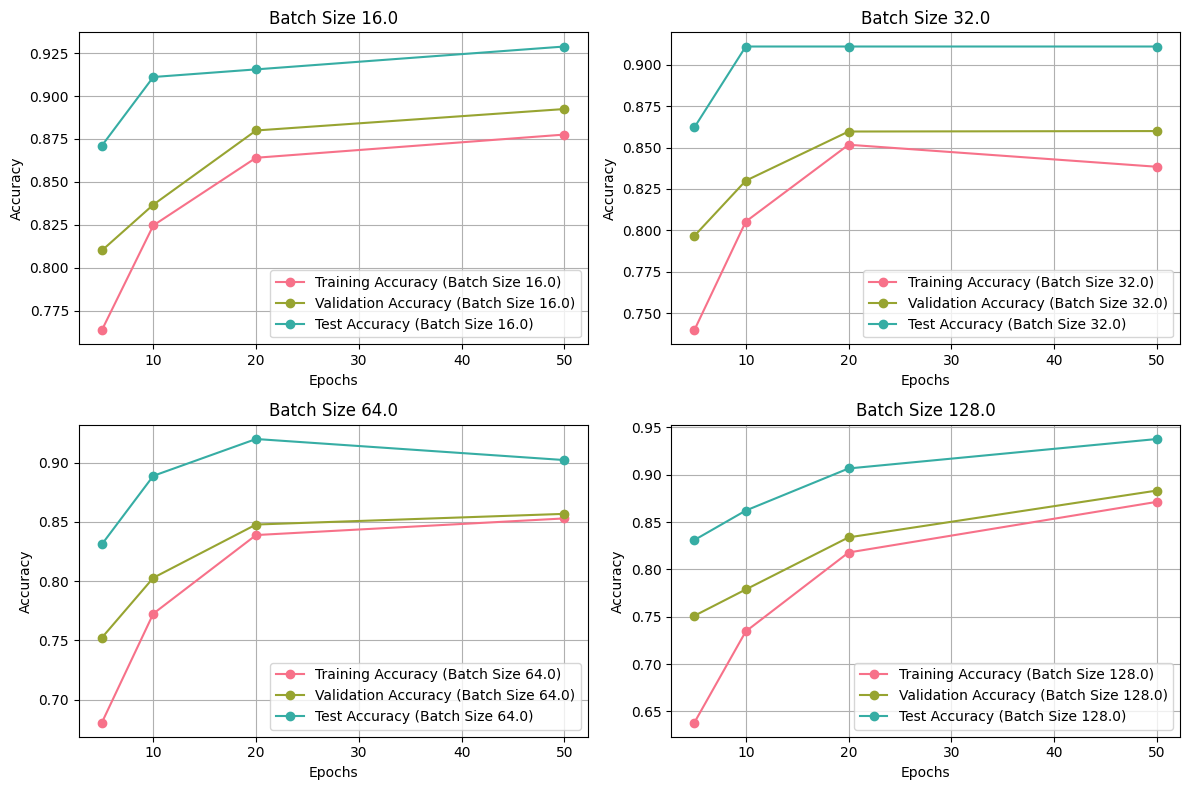

In [74]:
plot_accuracy(enhanced_model_output)

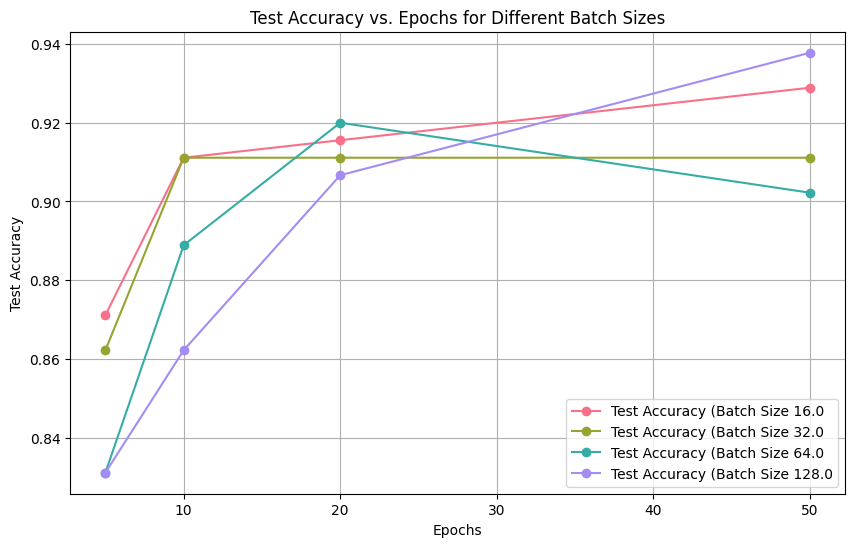

In [69]:
plot_test_accuracy(enhanced_model_output)

From the above, it is worthy to note that across all different combinations of Batch Size and Epoch, the test accuracy shows a steady increase along with training, and validation accuracy as epoch increases. The test accuracy in general is around 90% and the training and validation accuracy can in general reach around 85%, showing the model can continute learning in the training and validation set. This is a good sign that the model is performing well and the model is able to capture relationship that's complex enough to yield increasingly accurate predictions. 

It is worthy to note that early stopping does play a role while formulating a proper model. From the log of training, it appears that early stopping intervenes at the combination of 
batch=16, epoch=20  
batch=16, epoch=50  
batch=32, epoch=50  
batch=64, epoch=50  
batch=128, epoch=50  

This has indicated several interesting findings:  
1. With the boost of early stopping, the model is capable of running under different combinations of batch size and epoch, which is a really power technique to make the model to be generalizable enough in terms of different combinations of batch size and epoch.

2. It appears that epoch=50 is too many iterations for this particular model to achieve the optimal outcomes, and from a detailed record of the training log, the optimal training epoch, in general, would be around 30 epochs for this particular model.

3. This model is performing well to cature suffciently complex relationship while do not possess overfitting or underfitting problems. The next step would be to hyperparameter tuning for this given model structure in order to obtain an optimal model.

# Hyperparameter Tuning


From the training log of the above modellings, which all outputs decent model prediction capabilities, we can fairly conclude that epochs of 30 is capable of producing sufficiently great prediction performance. It is very important to combine the results and insights obatined above while exploring for additional hyperparameters. Therefore, for the rest of the hyperparameter tuning, we can set epoch=30 directly.

In [50]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np

def enhanced_vgg_16_hyperparameter_tuning(X, y, df, epochs, batch_sizes):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

    num_labels = len(np.unique(df['label']))
    y_train = np.eye(num_labels)[Y_train]
    y_test = np.eye(num_labels)[Y_test]
    y_val = np.eye(num_labels)[Y_val]

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    train_datagen.fit(X_train)

    # Hyperparameters to explore
    dropout_rates = [0.3, 0.5, 0.7]
    l2_regularizations = [0.001, 0.01, 0.1]

    best_accuracy = 0.0
    best_params = {}
    best_batch_size = None

    results = {}  # Store results for each batch size

    for batch_size in batch_sizes:
        batch_size_results = []  # Store results for current batch size

        for dropout_rate in dropout_rates:
            for l2_regularization in l2_regularizations:
                # Initialize the base model
                base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
                for layer in base_model.layers:
                    layer.trainable = False

                x = base_model.output
                x = GlobalAveragePooling2D()(x)
                x = Dense(512, activation='relu', kernel_regularizer=l2(l2_regularization))(x)
                x = Dropout(dropout_rate)(x)
                predictions = Dense(num_labels, activation='softmax')(x)
                model = Model(inputs=base_model.input, outputs=predictions)

                # Compile the model
                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

                # Early stopping
                early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

                # Fit the model with augmented data
                history = model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop]
                )

                test_predictions = model.predict(X_test)
                predicted_labels = np.argmax(test_predictions, axis=1)
                accuracy = np.mean(predicted_labels == Y_test)

                # Store the accuracy for current hyperparameters
                batch_size_results.append({'dropout_rate': dropout_rate,
                                           'l2_regularization': l2_regularization,
                                           'accuracy': accuracy})

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {'dropout_rate': dropout_rate, 'l2_regularization': l2_regularization}
                    best_batch_size = batch_size

        # Store the results for current batch size
        results[batch_size] = batch_size_results

    return best_params, best_accuracy, best_batch_size, results



In [55]:
batch_sizes_list=[16,32,64,128]
enhanced_vgg_16_hyperparameter_tuning(X, y, df, 30, batch_sizes=batch_sizes_list)

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/30
45/45 [==============================] - 7s 129ms/step - loss: 1.2632 - accuracy: 0.6597 - val_loss: 0.9088 - val_accuracy: 0.7611
Epoch 2/30
45/45 [==============================] - 4s 96ms/step - loss: 0.7805 - accuracy: 0.7972 - val_loss: 0.7288 - val_accuracy: 0.8056
Epoch 3/30
45/45 [==============================] - 4s 99ms/step - loss: 0.6329 - accuracy: 0.8361 - val_loss: 0.6432 - val_accuracy: 0.8222
Epoch 4/30
45/45 [==============================] - 5s 112ms/step - loss: 0.5314 - accuracy: 0.8750 - val_loss: 0.6406 - val_accuracy: 0.8000
Epoch 5/30
45/45 [==============================] - 5s 102ms/step - loss: 0.5105 - accuracy: 0.8861 - val_loss: 0.5422 - val_accuracy: 0.8556
Epoch 6/30
45/45 [==============================] - 5s 121ms/step - loss: 0.4451 - accuracy: 0.8917 - val_loss: 0.5240 - val_accuracy: 0.8556
Epoch 7/30
45/45 [==============================] - 5s 103ms/step - loss: 0.4397 - ac

({'dropout_rate': 0.3, 'l2_regularization': 0.001},
 0.9422222222222222,
 16,
 {16: [{'dropout_rate': 0.3,
    'l2_regularization': 0.001,
    'accuracy': 0.9422222222222222},
   {'dropout_rate': 0.3,
    'l2_regularization': 0.01,
    'accuracy': 0.9111111111111111},
   {'dropout_rate': 0.3,
    'l2_regularization': 0.1,
    'accuracy': 0.8088888888888889},
   {'dropout_rate': 0.5,
    'l2_regularization': 0.001,
    'accuracy': 0.9377777777777778},
   {'dropout_rate': 0.5,
    'l2_regularization': 0.01,
    'accuracy': 0.9111111111111111},
   {'dropout_rate': 0.5,
    'l2_regularization': 0.1,
    'accuracy': 0.7866666666666666},
   {'dropout_rate': 0.7,
    'l2_regularization': 0.001,
    'accuracy': 0.9066666666666666},
   {'dropout_rate': 0.7,
    'l2_regularization': 0.01,
    'accuracy': 0.8711111111111111},
   {'dropout_rate': 0.7,
    'l2_regularization': 0.1,
    'accuracy': 0.8044444444444444}],
  32: [{'dropout_rate': 0.3, 'l2_regularization': 0.001, 'accuracy': 0.88},
   {

It appears that from the above hyperparameter tuning, the best performing combination of choices for each Batch Size is   
Batch size 16: {'dropout_rate': 0.3, 'l2_regularization': 0.001} - Accuracy: 0.9422222222222222  
Batch size 32: {'dropout_rate': 0.3, 'l2_regularization': 0.001} - Accuracy: 0.88   
Batch size 64: {'dropout_rate': 0.3, 'l2_regularization': 0.001} - Accuracy: 0.9244444444444444  
Batch size 128: {'dropout_rate': 0.3, 'l2_regularization': 0.001} - Accuracy: 0.9244444444444444   

Throuout different the above four choices, it appears that the model performs the best when the dropout_rate is 0.3, l2_regularization is 0.001, and Batch Size=16.
We have also concluded the optimal epoch size is 30.  

# An optimal model should be implemented for saving purpose:

In [57]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, save_model


# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

num_labels = len(np.unique(df['label']))
y_train = np.eye(num_labels)[Y_train]
y_test = np.eye(num_labels)[Y_test]
y_val = np.eye(num_labels)[Y_val]

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)

# Initialize the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # Adding L2 regularization
x = Dropout(0.3)(x)  # Adding Dropout layer
predictions = Dense(num_labels, activation='softmax')(x)
optimal_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with augmented data
history = optimal_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

# Evaluate the model on the test set
test_predictions = optimal_model.predict(X_test)
predicted_labels = np.argmax(test_predictions, axis=1)
accuracy = np.mean(predicted_labels == Y_test)




# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))


Epoch 1/30
45/45 [==============================] - 7s 130ms/step - loss: 1.2766 - accuracy: 0.6222 - val_loss: 0.9571 - val_accuracy: 0.7222
Epoch 2/30
45/45 [==============================] - 4s 96ms/step - loss: 0.7708 - accuracy: 0.8056 - val_loss: 0.7299 - val_accuracy: 0.8000
Epoch 3/30
45/45 [==============================] - 6s 129ms/step - loss: 0.6254 - accuracy: 0.8486 - val_loss: 0.6422 - val_accuracy: 0.8111
Epoch 4/30
45/45 [==============================] - 4s 94ms/step - loss: 0.5251 - accuracy: 0.8861 - val_loss: 0.6167 - val_accuracy: 0.8500
Epoch 5/30
45/45 [==============================] - 5s 100ms/step - loss: 0.4878 - accuracy: 0.8875 - val_loss: 0.6280 - val_accuracy: 0.8056
Epoch 6/30
45/45 [==============================] - 6s 138ms/step - loss: 0.4785 - accuracy: 0.8833 - val_loss: 0.5714 - val_accuracy: 0.8667
Epoch 7/30
45/45 [==============================] - 4s 96ms/step - loss: 0.4533 - accuracy: 0.8903 - val_loss: 0.5247 - val_accuracy: 0.8833
Epoch 8/3

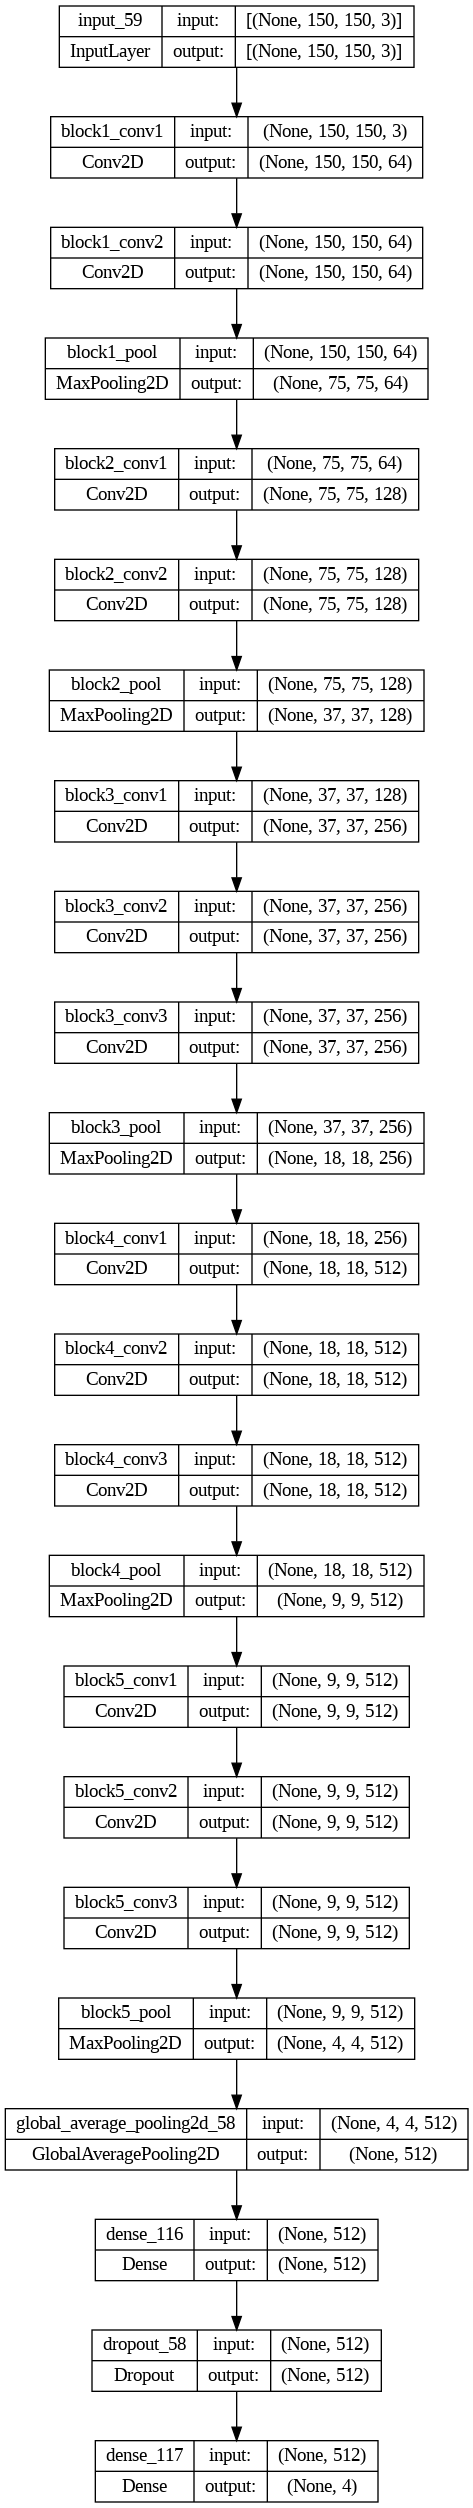

In [59]:
#plot the structure of the optimal model
plot_model(optimal_model,to_file="optimalVGG16.png",show_shapes=True,show_layer_names=True)
Image(filename="optimalVGG16.png")

In [61]:
# Save the model
optimal_model.save('/content/drive/MyDrive/vgg16_model.h5')
print("The model has been saved")

The model has been saved


In [62]:
#test if the same model can be reloaded
reloaded_model = tf.keras.models.load_model('/content/drive/MyDrive/vgg16_model.h5')
print("The model has been reloaded")

The model has been reloaded


# Conclusion
The main objective of this project is to identify an optimal model for weather image classification, incorporating useful techniques. These techniques include but are not limited to regularization, data augmentation, and early stopping. By utilizing these techniques, the project aims to save computational resources by determining the optimal combination of epochs and batch size that accurately reflects the model's prediction capabilities.

It is important to note that there are various options available for modeling structures and regularization techniques, and it is highly recommended to explore and implement different choices. However, based on the specific dataset provided for this project, it can be reasonably concluded that transfer learning models from the VGG16 model, along with appropriate regularization techniques, are sufficient to generate reasonable predictions. These models exhibit decent values of loss and accuracy when evaluated on the testing, training, and validation datasets.

